In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 import os, textwrap
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, ' -> ', len(filenames), 'files')
    # klasör adlarını kısa görmek için
    for f in filenames[:5]:
        print('   ', f)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# /kaggle/input altındaki her şeyi listele
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname, '->', len(filenames), 'files')
    for f in filenames[:5]:  # her klasörden ilk 5 dosyayı göster
        print('   ', f)


In [ ]:
import os
for d, _, files in os.walk('/kaggle/input/deepglobe-road-extraction-dataset'):
    print(d, '->', len(files))
    print(files[:5])


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Örnek bir ID seçelim
img_id = "803431"   # train klasöründeki sat ve mask aynı ID ile eşleşiyor

sat_img = mpimg.imread(f'/kaggle/input/deepglobe-road-extraction-dataset/train/{img_id}_sat.jpg')
mask_img = mpimg.imread(f'/kaggle/input/deepglobe-road-extraction-dataset/train/{img_id}_mask.png')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(sat_img)
axs[0].set_title("Satellite")
axs[1].imshow(mask_img, cmap='gray')
axs[1].set_title("Mask")
plt.show()


In [ ]:
from pathlib import Path

BASE = Path("/kaggle/input/deepglobe-road-extraction-dataset")

# Case A: /train/satellite/*.jpg  +  /train/mask/*.png
sat_A = list((BASE/"train"/"satellite").glob("*.jpg")) + list((BASE/"train"/"satellite").glob("*.png"))
mask_dir_A = BASE/"train"/"mask"

# Case B: /train/*.jpg  +  /train_masks/*_mask.(png|gif|jpg)
sat_B = list((BASE/"train").glob("*.jpg")) + list((BASE/"train").glob("*.png"))
mask_dir_B = BASE/"train_masks"

case = "A" if (len(sat_A) > 0 and mask_dir_A.exists()) else "B"

def pair_paths(sat_paths, case):
    sat, msk = [], []
    for sp in sorted(sat_paths):
        if case == "A":
            cand = [(sp.parent.parent/"mask"/(sp.stem + ext)) for ext in (".png", ".jpg")]
        else:
            base = sp.stem
            cand = [
                mask_dir_B/f"{base}_mask.png",
                mask_dir_B/f"{base}_mask.gif",
                mask_dir_B/f"{base}_mask.jpg",
                mask_dir_B/f"{base}.png",
                mask_dir_B/f"{base}.gif",
                mask_dir_B/f"{base}.jpg",
            ]
        mp = next((c for c in cand if c.exists()), None)
        if mp is not None:
            sat.append(sp); msk.append(mp)
    return sat, msk

sat_paths, mask_paths = pair_paths(sat_A if case=="A" else sat_B, case)

len(sat_paths), len(mask_paths), case, sat_paths[0], mask_paths[0]


In [ ]:
from pathlib import Path
BASE = Path("/kaggle/input/deepglobe-road-extraction-dataset")

for p in sorted(BASE.rglob("*")):
    if p.is_dir():
        print("[DIR]", p)
    else:
        if p.suffix.lower() in [".jpg",".jpeg",".png",".tif",".tiff",".gif"]:
            print("     ", p)


In [ ]:
from pathlib import Path
import re
from sklearn.model_selection import train_test_split

BASE = Path("/kaggle/input/deepglobe-road-extraction-dataset")
TRAIN_DIR = BASE / "train"

# Dosyaları topla
sat_files  = sorted([p for p in TRAIN_DIR.glob("*_sat.*")])
mask_files = sorted([p for p in TRAIN_DIR.glob("*_mask.*")])

# ID çıkaran yardımcı
def get_id(p: Path):
    m = re.search(r"(\d+)_sat", p.stem) or re.search(r"(\d+)_mask", p.stem)
    return m.group(1) if m else None

sat_map  = {get_id(p): p for p in sat_files}
mask_map = {get_id(p): p for p in mask_files}

ids = sorted(set(sat_map) & set(mask_map))
sat_paths  = [sat_map[i]  for i in ids]
mask_paths = [mask_map[i] for i in ids]

print("Toplam eşleşen çift:", len(ids))
print("Örnek:", sat_paths[0], "\n      ", mask_paths[0])


In [ ]:
from sklearn.model_selection import train_test_split

# sat_paths ve mask_paths önceki adımda oluşturduğun listeler
train_sat, val_sat, train_msk, val_msk = train_test_split(
    sat_paths, mask_paths, test_size=0.2, shuffle=True, random_state=42
)

print("Train samples :", len(train_sat))
print("Valid samples :", len(val_sat))
print("Örnek train   :", train_sat[0], "\n                ", train_msk[0])
print("Örnek valid   :", val_sat[0],   "\n                ", val_msk[0])


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Sabitler ----
IMG_SIZE   = 512       # (1024 -> 512: bellek/ hız için iyi denge)
BATCH_SIZE = 4
AUTOTUNE   = tf.data.AUTOTUNE

# Yol listelerini tf.data'ya çevir
train_ds_paths = tf.data.Dataset.from_tensor_slices((train_sat, train_msk))
val_ds_paths   = tf.data.Dataset.from_tensor_slices((val_sat,   val_msk))

def load_pair(sat_path, mask_path):
    # Görüntü
    img = tf.io.read_file(sat_path)
    img = tf.image.decode_jpeg(img, channels=3)            # .jpg
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)    # [0,1]

    # Maske (beyaz yollar / siyah arka plan)
    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_png(msk, channels=1)             # .png
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    msk = tf.image.convert_image_dtype(msk, tf.float32)    # [0,1]
    # ikili (0/1) hale getir
    msk = tf.where(msk > 0.5, 1.0, 0.0)

    return img, msk

@tf.function
def random_flip_rotate(img, msk):
    # Yatay/dikey flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img);   msk = tf.image.flip_up_down(msk)
    # 0,90,180,270 derece rastgele döndür
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k); msk = tf.image.rot90(msk, k)
    return img, msk

def make_pipeline(path_ds, training=True):
    ds = path_ds.map(load_pair, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(random_flip_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_pipeline(train_ds_paths, training=True)
val_ds   = make_pipeline(val_ds_paths,   training=False)

# Hızlı görsel kontrol: bir batch'ten 3 örnek göster
imgs, msks = next(iter(train_ds))
plt.figure(figsize=(10,6))
for i in range(3):
    plt.subplot(2,3,i+1);   plt.imshow(imgs[i]); plt.axis("off"); plt.title("Satellite")
    plt.subplot(2,3,i+4);   plt.imshow(msks[i].numpy().squeeze(), cmap="gray"); plt.axis("off"); plt.title("Mask")
plt.tight_layout(); plt.show()

print("train batch shape:", imgs.shape, " mask:", msks.shape)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Yolları string'e çevir
train_sat = [str(p) for p in train_sat]
train_msk = [str(p) for p in train_msk]
val_sat   = [str(p) for p in val_sat]
val_msk   = [str(p) for p in val_msk]

# 2) tf.data slice
train_ds_paths = tf.data.Dataset.from_tensor_slices(
    (tf.constant(train_sat), tf.constant(train_msk))
)
val_ds_paths = tf.data.Dataset.from_tensor_slices(
    (tf.constant(val_sat), tf.constant(val_msk))
)

# 3) Loader + augment (öncekiyle aynıysa tekrar çalışsın)
IMG_SIZE   = 512
BATCH_SIZE = 4
AUTOTUNE   = tf.data.AUTOTUNE

def load_pair(sat_path, mask_path):
    img = tf.io.read_file(sat_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)

    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    msk = tf.image.convert_image_dtype(msk, tf.float32)
    msk = tf.where(msk > 0.5, 1.0, 0.0)  # ikili maske
    return img, msk

@tf.function
def random_flip_rotate(img, msk):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img);   msk = tf.image.flip_up_down(msk)
    k = tf.random.uniform((), 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k); msk = tf.image.rot90(msk, k)
    return img, msk

def make_pipeline(path_ds, training=True):
    ds = path_ds.map(load_pair, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(random_flip_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_pipeline(train_ds_paths, training=True)
val_ds   = make_pipeline(val_ds_paths,   training=False)

# 4) Hızlı kontrol
imgs, msks = next(iter(train_ds))
print("train batch:", imgs.shape, msks.shape)

plt.figure(figsize=(10,6))
for i in range(3):
    plt.subplot(2,3,i+1); plt.imshow(imgs[i]); plt.axis("off"); plt.title("Satellite")
    plt.subplot(2,3,i+4); plt.imshow(msks[i].numpy().squeeze(), cmap="gray"); plt.axis("off"); plt.title("Mask")
plt.tight_layout(); plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 512
NUM_CLASSES = 1  # road = 1, background = 0

def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, f):
    c = conv_block(x, f)
    p = layers.MaxPool2D()(c)
    return c, p

def decoder_block(x, skip, f):
    x = layers.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, f)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs,   32)
    s2, p2 = encoder_block(p1,       64)
    s3, p3 = encoder_block(p2,      128)
    s4, p4 = encoder_block(p3,      256)

    b = conv_block(p4, 512)  # bottleneck

    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2,  64)
    d4 = decoder_block(d3, s1,  32)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation="sigmoid")(d4)
    return keras.Model(inputs, outputs, name="U-Net")

model = build_unet()
model.summary()


In [ ]:
# GPU pipeline hızlandırma
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,                     # istersen 20’ye çekebilirsin
    callbacks=[es, rlr, ckp],      # önceki hücrede tanımlamıştık
    verbose=1
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# En iyi val_iou_metric değerine göre erken durdur
es  = EarlyStopping(
    monitor='val_iou_metric', mode='max',
    patience=5, restore_best_weights=True, verbose=1
)

# Öğrenme oranını düşür
rlr = ReduceLROnPlateau(
    monitor='val_iou_metric', mode='max',
    factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# En iyi modeli kaydet
ckp = ModelCheckpoint(
    '/kaggle/working/best_unet.keras',
    monitor='val_iou_metric', mode='max',
    save_best_only=True, verbose=1
)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[es, rlr, ckp],
    verbose=1
)


In [ ]:
plot_history(history)
show_predictions(val_ds, n=3, thr=0.5)
model.save("/kaggle/working/unet_road_segmentation")
print("Kaydedildi:", "/kaggle/working/unet_road_segmentation")


In [ ]:
# === 0) Güvenlik: tüm gerekli import/objeler burada ===
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# train_ds, val_ds ve model zaten yukarıda tanımlı olmalı
# emin olmak için birer batch çekelim (hata verirse yukarıdaki pipeline hücrelerine dön)
imgs, msks = next(iter(train_ds))
print("Batch kontrol:", imgs.shape, msks.shape)

# === 1) Callback'ler ===
es  = EarlyStopping(monitor='val_iou_metric', mode='max', patience=5,
                    restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_iou_metric', mode='max',
                        factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckp = ModelCheckpoint('/kaggle/working/best_unet.keras',
                      monitor='val_iou_metric', mode='max',
                      save_best_only=True, verbose=1)

# === 2) Prefetch ve eğitim ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds_pref = train_ds.prefetch(AUTOTUNE)
val_ds_pref   = val_ds.prefetch(AUTOTUNE)

print("Eğitim başlıyor...")
history = model.fit(
    train_ds_pref,
    validation_data=val_ds_pref,
    epochs=30,
    callbacks=[es, rlr, ckp],
    verbose=1
)

# === 3) Grafikler ===
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(history.history['iou_metric']); plt.plot(history.history['val_iou_metric']); plt.title('IoU'); plt.legend(['train','val'])
if 'dice_coef' in history.history:
    plt.subplot(1,3,2); plt.plot(history.history['dice_coef']); plt.plot(history.history['val_dice_coef']); plt.title('Dice'); plt.legend(['train','val'])
plt.subplot(1,3,3); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.title('Loss'); plt.legend(['train','val'])
plt.tight_layout(); plt.show()

# === 4) Örnek tahminler ===
def show_predictions(ds, n=3, thr=0.5):
    x, y = next(iter(ds))
    p = model.predict(x, verbose=0)
    p = (p > thr).astype(np.float32)
    for i in range(n):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1); plt.imshow(x[i].numpy()); plt.title("Satellite"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(y[i].numpy().squeeze(), cmap='gray'); plt.title("GT Mask"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(p[i].squeeze(), cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
        plt.show()

show_predictions(val_ds_pref, n=3, thr=0.5)

# === 5) Kaydet ===
model.save("/kaggle/working/unet_road_segmentation")
print("Modeller kaydedildi:",
      "/kaggle/working/unet_road_segmentation",
      "ve (en iyi checkpoint): /kaggle/working/best_unet.keras")


In [ ]:
# === Kayıp ve metrikler ===
import tensorflow as tf

# IoU (Jaccard)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)          # threshold
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union        = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

# Dice
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denom = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    dice = (2. * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

# BCE + Dice loss
def bce_dice_loss(y_true, y_pred):
    bce  = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1. - dice_coef(y_true, y_pred)
    return bce + dice

# === Modeli derle ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=bce_dice_loss,
    metrics=[iou_metric, dice_coef, 'accuracy']  # callbacks'ta 'val_iou_metric' izleyeceğiz
)

print("Model derlendi.")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# En iyi modeli kaydet
ckp = ModelCheckpoint(
    '/kaggle/working/best_unet.keras',
    monitor='val_iou_metric', mode='max',
    save_best_only=True, verbose=1
)

# Val metrik iyileşmiyorsa erken durdur
es = EarlyStopping(
    monitor='val_iou_metric', mode='max',
    patience=5, restore_best_weights=True, verbose=1
)

# Öğrenme oranını düşür
rlr = ReduceLROnPlateau(
    monitor='val_iou_metric', mode='max',
    factor=0.5, patience=2, min_lr=1e-6, verbose=1
)
print("Callback'ler hazır.")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_pref = train_ds.cache().shuffle(512).prefetch(AUTOTUNE)
val_ds_pref   = val_ds.cache().prefetch(AUTOTUNE)

imgs, msks = next(iter(train_ds_pref))
print("Batch kontrol:", imgs.shape, msks.shape)


In [ ]:
history = model.fit(
    train_ds_pref,
    validation_data=val_ds_pref,
    epochs=30,                 # istersen 15-20 ile başla
    callbacks=[es, rlr, ckp],
    verbose=1
)


In [ ]:
import matplotlib.pyplot as plt
h = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title('Loss'); plt.legend(['train','val'])
plt.subplot(1,2,2); plt.plot(h['iou_metric']); plt.plot(h['val_iou_metric']); plt.title('IoU'); plt.legend(['train','val'])
plt.show()


In [ ]:
IMG_SIZE   = 256   # 512 → 256
BATCH_SIZE = 1     # 4 → 1
EPOCHS     = 3     # önce kısa
steps_per_epoch    = 150   # küçük tut
validation_steps   = 40


In [ ]:
import os, tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
tf.config.optimizer.set_jit(False)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


In [ ]:
import os
# Günlükleri sessize al
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"     # 0=hepsi, 1=INFO kapat, 2=WARNING kapat, 3=ERROR kapat
# XLA/JIT kapat (ilk etapta stabil)
os.environ["TF_ENABLE_XLA"] = "0"
# Tek GPU kullan (Kaggle'da 2 T4 görünür, biri yeter)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# TF GPU bellek büyümesi
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass


In [ ]:
# use a tiny subset so it finishes fast
small_train = train_ds_pref.take(200)
small_val   = val_ds_pref.take(40)

EPOCHS = 2  # first run short

history = model.fit(
    small_train,
    validation_data=small_val,
    epochs=EPOCHS,
    callbacks=[es, rlr, ckp],   # senin tanımladıkların
    verbose=1
)


In [ ]:
import tensorflow as tf, numpy as np
from pathlib import Path
import random

# === Ayarlar (hafif tutuyoruz) ===
IMG_SIZE   = 256          # 512 yerine 256: GPU/RAM rahatlar
BATCH_SIZE = 4            # önce küçük batch
AUTOTUNE   = tf.data.AUTOTUNE

root = Path("/kaggle/input/deepglobe-road-extraction-dataset/train")

# Tüm sat ve mask yollarını eşle
sat_paths = sorted(str(p) for p in root.glob("*_sat.jpg"))
pairs = []
for sp in sat_paths:
    mp = sp.replace("_sat.jpg", "_mask.png")
    if Path(mp).exists():
        pairs.append((sp, mp))

print("Toplam eşleşen çift:", len(pairs))
random.seed(42); random.shuffle(pairs)

# 80/20 split
split_idx = int(len(pairs) * 0.8)
train_pairs = pairs[:split_idx]
val_pairs   = pairs[split_idx:]

train_sat = [s for s,m in train_pairs]
train_msk = [m for s,m in train_pairs]
val_sat   = [s for s,m in val_pairs]
val_msk   = [m for s,m in val_pairs]

def load_example(sat_path, msk_path):
    # sat
    img = tf.io.read_file(sat_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # mask
    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)   # binarize 0/1

    return img, msk

def make_ds(sats, msks, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((sats, msks))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(sats), 2000), reshuffle_each_iteration=True)
    ds = ds.map(lambda s,m: load_example(s, m), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_pref = make_ds(train_sat, train_msk, shuffle=True)
val_ds_pref   = make_ds(val_sat,   val_msk,   shuffle=False)

# Küçük bir batch göster
x_b, y_b = next(iter(train_ds_pref))
print("Batch kontrol:", x_b.shape, y_b.shape)


In [ ]:
# Model derli değilse derle (güvenli tekrar derleme)
try:
    _ = getattr(tf.keras.Model, "compiled_loss")
    # zaten compile ettiysen bu satır sorun çıkarmaz; emin olmak için:
except Exception:
    pass

if not getattr(getattr(globals().get("model", None), "__dict__", {}), "compiled_loss", None):
    # Basit derleme – istersen kendi loss/metriklerini kullan
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy")
        ]
    )

# Çok küçük subset ile 1-2 epoch hızlı deneme
small_train = train_ds_pref.take(200)
small_val   = val_ds_pref.take(40)

EPOCHS = 2
history = model.fit(
    small_train,
    validation_data=small_val,
    epochs=EPOCHS,
    verbose=1
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L

# --- Küçük U-Net (hafif: 16-32-64-128 filtre) ---
def conv_block(x, f):
    x = L.Conv2D(f, 3, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    x = L.Conv2D(f, 3, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    return x

def up_block(x, skip, f):
    x = L.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = L.Concatenate()([x, skip])
    x = conv_block(x, f)
    return x

def build_unet(img_size=256, base=16):
    inp = L.Input((img_size, img_size, 3))

    # Encoder
    c1 = conv_block(inp, base)        ; p1 = L.MaxPool2D()(c1)
    c2 = conv_block(p1, base*2)       ; p2 = L.MaxPool2D()(c2)
    c3 = conv_block(p2, base*4)       ; p3 = L.MaxPool2D()(c3)
    c4 = conv_block(p3, base*8)       ; p4 = L.MaxPool2D()(c4)

    # Bottleneck
    bn = conv_block(p4, base*16)

    # Decoder
    u1 = up_block(bn, c4, base*8)
    u2 = up_block(u1, c3, base*4)
    u3 = up_block(u2, c2, base*2)
    u4 = up_block(u3, c1, base*1)

    # Çıkış (sigmoid). Tipi float32 tutalım ki metrikler problemsiz olsun.
    out = L.Conv2D(1, 1, activation="sigmoid", dtype="float32")(u4)

    return tf.keras.Model(inp, out, name="unet_small")

# Eğer datasetler yoksa önce onları kurmalısın (train_ds_pref / val_ds_pref).
# Burada sadece model + derleme + kısa eğitim var.
model = build_unet(img_size=256, base=16)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Mini deneme: hızlı bitsin diye küçük subset
small_train = train_ds_pref.take(200)  # ~200 batch değil, 200 step değil; 200 "batch" değil "take(200)" dataset element'i
small_val   = val_ds_pref.take(40)

# Basit callback'ler (opsiyonel)
es  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
ckp = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/unet_small.keras", monitor="val_loss", save_best_only=True
)

print(model.summary())
history = model.fit(
    small_train,
    validation_data=small_val,
    epochs=2,          # smoke test (kısa)
    callbacks=[es, ckp],
    verbose=1
)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# val_ds_pref -> (image, mask), image: [0,1] float32, mask: {0,1} float32
sample_ds = val_ds_pref.unbatch().take(3)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for r, (img, msk) in enumerate(sample_ds):
    img_b = tf.expand_dims(img, 0)
    prd = model.predict(img_b, verbose=0)[0, ... , 0]  # (H,W)

    axs[r,0].imshow(img.numpy())
    axs[r,0].set_title("Girdi")
    axs[r,0].axis("off")

    axs[r,1].imshow(msk.numpy().squeeze(), cmap="gray")
    axs[r,1].set_title("Gerçek Maske")
    axs[r,1].axis("off")

    axs[r,2].imshow(prd, cmap="gray")
    axs[r,2].set_title("Tahmin (prob)")
    axs[r,2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

def binarize(x, thr=0.5): 
    return tf.cast(x > thr, tf.float32)

def iou(y_true, y_pred, eps=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + eps) / (union + eps)

def dice(y_true, y_pred, eps=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2*inter + eps) / (total + eps)

# Val’den 80 örnek (~hızlı)
val_part = val_ds_pref.take(20)  # 20 batch * batch_size (ör. 4) ≈ 80 örnek
m_iou = tf.keras.metrics.Mean()
m_dice = tf.keras.metrics.Mean()

for batch_imgs, batch_msks in val_part:
    preds = model.predict(batch_imgs, verbose=0)
    preds_bin = binarize(preds)
    m_iou.update_state(iou(batch_msks, preds_bin))
    m_dice.update_state(dice(batch_msks, preds_bin))

print(f"Val IoU ~ {m_iou.result().numpy():.4f}")
print(f"Val Dice ~ {m_dice.result().numpy():.4f}")


In [ ]:
# val setinden 50 görüntülük bir parça al
chk = val_ds_pref.take(50)

gt_pix_mean = []
for x, y in chk:
    gt_pix_mean.append(float(tf.reduce_mean(y)))  # y ∈ [0,1] olmalı, >0 varsa yol pikselleri var demek

print("GT piksel ortalamalarının ilk 10’u:", gt_pix_mean[:10])
print("GT ortalama (tümü):", sum(gt_pix_mean)/len(gt_pix_mean))


In [ ]:
pred_pix_mean = []
for x, y in val_ds_pref.take(50):
    p = model.predict(x, verbose=0)           # (B,H,W,1) sigmoid çıktısı [0,1]
    pred_pix_mean.append(float(tf.reduce_mean(p)))

print("Pred piksel ortalamalarının ilk 10’u:", pred_pix_mean[:10])
print("Pred ortalama (tümü):", sum(pred_pix_mean)/len(pred_pix_mean))


In [ ]:
import tensorflow as tf

def binarize(x, thr=0.4):          # 0.5 yerine 0.4 deneyelim (gerekirse 0.3)
    return tf.cast(x > thr, tf.float32)

def iou_per_image(y_true, y_pred, eps=1e-7):
    # (B,H,W,1) -> her görüntü için IoU, sonra ortalama
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - inter
    return tf.reduce_mean((inter + eps) / (union + eps))

def dice_per_image(y_true, y_pred, eps=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    tot   = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2*inter + eps) / (tot + eps))

# Val'in küçük bir kısmı üzerinde hızlı ölçüm
part = val_ds_pref.take(20)  # 20 batch

m_iou = tf.keras.metrics.Mean()
m_dice= tf.keras.metrics.Mean()

for x, y in part:
    p  = model.predict(x, verbose=0)
    pb = binarize(p, 0.4)
    m_iou.update_state(iou_per_image(y, pb))
    m_dice.update_state(dice_per_image(y, pb))

print(f"[Val(part)] IoU ~ {m_iou.result().numpy():.4f}")
print(f"[Val(part)] Dice ~ {m_dice.result().numpy():.4f}")


In [ ]:
def load_pair(img_path, msk_path, img_size=(256,256)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, img_size, method='nearest')
    # kritik: 0/255 olabilir, o yüzden >0 ile 1 yap
    msk = tf.cast(msk > 0, tf.float32)

    return img, msk


In [ ]:
import tensorflow as tf, numpy as np, os, glob, random
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (256,256)
BATCH = 4

def load_pair(img_path, msk_path, img_size=IMG_SIZE):
    img = tf.io.read_file(img_path); img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path); msk = tf.image.decode_png(msk, 1)
    # ÖNEMLİ: maske için nearest resize + >0 binarize
    msk = tf.image.resize(msk, img_size, method='nearest')
    msk = tf.cast(msk > 0, tf.float32)
    return img, msk

def ds_from_paths(sat_paths, msk_paths, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((sat_paths, msk_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(2000, len(sat_paths)), reshuffle_each_iteration=True)
    ds = ds.map(lambda s, m: load_pair(s, m), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# NOT: train_sat/train_msk/val_sat/val_msk listelerin ESKİ hücreden geliyor olmalı
#     (Yoksa tekrar üret: aynı eşleştirme kodunu bir kez daha çalıştır)
train_ds = ds_from_paths(train_sat, train_msk, shuffle=True)
val_ds   = ds_from_paths(val_sat,   val_msk,   shuffle=False)

# ESKİ referansları unut → bundan sonra sadece bunları kullan
train_ds_pref = train_ds
val_ds_pref   = val_ds


In [ ]:
# GT tarafı gerçekten 0/1 mi?
gt_means = []
for x, y in val_ds_pref.take(30):
    gt_means.append(float(tf.reduce_mean(y)))
print("GT mean (örnek) ilk 10:", gt_means[:10], "| ort:", np.mean(gt_means))


In [ ]:
import matplotlib.pyplot as plt

def show_samples(ds, n=3, thr=0.4):
    for x, y in ds.take(n):
        p = model.predict(x, verbose=0)
        pb = (p > thr).astype("float32")
        bs = x.shape[0]
        for i in range(bs):
            fig, axs = plt.subplots(1,4, figsize=(12,3))
            axs[0].imshow(x[i]); axs[0].set_title("Image"); axs[0].axis('off')
            axs[1].imshow(y[i].numpy().squeeze(), cmap='gray'); axs[1].set_title("GT"); axs[1].axis('off')
            axs[2].imshow(p[i].squeeze(), cmap='magma'); axs[2].set_title("Pred prob"); axs[2].axis('off')
            axs[3].imshow(pb[i].squeeze(), cmap='gray'); axs[3].set_title(f"Pred bin (>{thr})"); axs[3].axis('off')
            plt.show()

show_samples(val_ds_pref.take(1), n=1, thr=0.4)


In [ ]:
def conv_blk(x, f):
    x = tf.keras.layers.Conv2D(f, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(f, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def up_blk(x, skip, f):
    x = tf.keras.layers.Conv2DTranspose(f, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    return conv_blk(x, f)

inp = tf.keras.Input((256,256,3), name="input")
x1 = conv_blk(inp, 16); p1 = tf.keras.layers.MaxPool2D()(x1)
x2 = conv_blk(p1, 32);  p2 = tf.keras.layers.MaxPool2D()(x2)
x3 = conv_blk(p2, 64);  p3 = tf.keras.layers.MaxPool2D()(x3)
x4 = conv_blk(p3, 128); p4 = tf.keras.layers.MaxPool2D()(x4)
bn = conv_blk(p4, 256)

u1 = up_blk(bn, x4, 128)
u2 = up_blk(u1, x3, 64)
u3 = up_blk(u2, x2, 32)
u4 = up_blk(u3, x1, 16)

# ÇIKTI: 1 kanal + SIGMOID
out = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name="mask")(u4)

model = tf.keras.Model(inp, out)


In [ ]:
# pozitif piksel oranını kabaca ölç (hızlı)
import numpy as np, tensorflow as tf
pos_means = []
for x, y in train_ds_pref.take(50):
    pos_means.append(float(tf.reduce_mean(y)))
p_pos = max(1e-4, min(0.5, np.mean(pos_means)))  # 0 ile 0.5 arası kıs
print("p_pos ~", p_pos)


In [ ]:
bias_init = tf.keras.initializers.Constant(np.log(p_pos/(1-p_pos)))
out = tf.keras.layers.Conv2D(1, 1, activation='sigmoid',
                             bias_initializer=bias_init, name="mask")(u4)


In [ ]:
def dice_loss(y_true, y_pred, eps=1e-7):
    inter = tf.reduce_sum(y_true*y_pred, axis=[1,2,3])
    tot   = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return 1. - tf.reduce_mean((2*inter+eps)/(tot+eps))

def bce_dice(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=bce_dice,
              metrics=['accuracy'])


In [ ]:
pred_means = []
for x, y in val_ds_pref.take(5):
    p = model.predict(x, verbose=0)
    pred_means.append(float(tf.reduce_mean(p)))
print("Pred mean ~", np.mean(pred_means))  # ~0.02–0.15 arası normal

THR = 0.3  # şimdilik düşük


In [ ]:
import matplotlib.pyplot as plt
for x, y in val_ds_pref.take(1):
    p = model.predict(x, verbose=0)
    pb = (p > THR).astype("float32")
    for i in range(min(3, x.shape[0])):
        fig, axs = plt.subplots(1,4, figsize=(12,3))
        axs[0].imshow(x[i]); axs[0].set_title("Image"); axs[0].axis('off')
        axs[1].imshow(y[i].numpy().squeeze(), cmap='gray'); axs[1].set_title("GT"); axs[1].axis('off')
        axs[2].imshow(p[i].squeeze(), cmap='magma'); axs[2].set_title("Prob"); axs[2].axis('off')
        axs[3].imshow(pb[i].squeeze(), cmap='gray'); axs[3].set_title(f"Bin>{THR}"); axs[3].axis('off')
        plt.show()


In [ ]:
THR = 0.2   # 0.3 yerine daha düşük eşik


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Örnek valid sample al
val_sample = next(iter(val_ds_pref.unbatch().batch(1)))
img, msk = val_sample

# Model tahmini
pred = model.predict(img)
pred = pred[0, :, :, 0]

print("Prediction mean:", np.mean(pred))

# Farklı threshold denemeleri
bin_02 = (pred > 0.2).astype(np.uint8)
bin_03 = (pred > 0.3).astype(np.uint8)

# Görselleştirme
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(pred, cmap="gray"); plt.title("Raw prediction")
plt.subplot(1,3,2); plt.imshow(bin_02, cmap="gray"); plt.title("Threshold 0.2")
plt.subplot(1,3,3); plt.imshow(bin_03, cmap="gray"); plt.title("Threshold 0.3")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Örnek valid sample al
val_sample = next(iter(val_ds_pref.unbatch().batch(1)))
img, msk = val_sample

# Model tahmini
pred = model.predict(img)
pred = pred[0, :, :, 0]

print("Prediction mean:", np.mean(pred))

# Farklı threshold denemeleri
bin_02 = (pred > 0.2).astype(np.uint8)
bin_03 = (pred > 0.3).astype(np.uint8)

# Görselleştirme
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(pred, cmap="gray"); plt.title("Raw prediction")
plt.subplot(1,3,2); plt.imshow(bin_02, cmap="gray"); plt.title("Threshold 0.2")
plt.subplot(1,3,3); plt.imshow(bin_03, cmap="gray"); plt.title("Threshold 0.3")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Örnek valid sample al
val_sample = next(iter(val_ds_pref.unbatch().batch(1)))
img, msk = val_sample

# Model tahmini
pred = model.predict(img)
pred = pred[0, :, :, 0]

print("Prediction mean:", np.mean(pred))

# Farklı threshold denemeleri
bin_02 = (pred > 0.2).astype(np.uint8)
bin_03 = (pred > 0.3).astype(np.uint8)

# Görselleştirme
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(pred, cmap="gray"); plt.title("Raw prediction")
plt.subplot(1,3,2); plt.imshow(bin_02, cmap="gray"); plt.title("Threshold 0.2")
plt.subplot(1,3,3); plt.imshow(bin_03, cmap="gray"); plt.title("Threshold 0.3")
plt.show()


In [ ]:
# 1) Valid’den tek örnek al
sample = next(iter(val_ds_pref.unbatch().batch(1)))
img, msk = sample
import numpy as np

print("mask dtype:", msk.dtype, "min/max:", float(msk.numpy().min()), float(msk.numpy().max()),
      "mean:", float(msk.numpy().mean()))

# 2) Model çıktı aralığını kontrol et (sigmoid var mı/yok mu?)
raw = model.predict(img)[0,...,0]
print("pred min/max/mean:", float(raw.min()), float(raw.max()), float(raw.mean()))


In [ ]:
# SON KATMANI şöyle değiştir:
output = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid", dtype="float32")(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name="UNetTiny")


In [ ]:
import tensorflow as tf

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def unet_tiny(input_shape=(256,256,3), base=16):
    inputs = tf.keras.Input(shape=input_shape, name="input_layer")
    x = tf.keras.layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast")(inputs)

    # Encoder
    c1 = conv_block(x, base)          # 256
    p1 = tf.keras.layers.MaxPooling2D()(c1)    # 128
    c2 = conv_block(p1, base*2)       # 128
    p2 = tf.keras.layers.MaxPooling2D()(c2)    # 64
    c3 = conv_block(p2, base*4)       # 64
    p3 = tf.keras.layers.MaxPooling2D()(c3)    # 32
    c4 = conv_block(p3, base*8)       # 32

    # Decoder
    u3 = tf.keras.layers.Conv2DTranspose(base*4, 2, strides=2, padding="same")(c4)  # 64
    u3 = tf.keras.layers.Concatenate()([u3, c3])
    c5 = conv_block(u3, base*4)

    u2 = tf.keras.layers.Conv2DTranspose(base*2, 2, strides=2, padding="same")(c5)  # 128
    u2 = tf.keras.layers.Concatenate()([u2, c2])
    c6 = conv_block(u2, base*2)

    u1 = tf.keras.layers.Conv2DTranspose(base, 2, strides=2, padding="same")(c6)    # 256
    u1 = tf.keras.layers.Concatenate()([u1, c1])
    c7 = conv_block(u1, base)

    # Çıkış: sigmoid (0–1)
    c7 = tf.keras.layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast_1")(c7)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid", dtype="float32")(c7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="UNetTiny")
    return model

model = unet_tiny(input_shape=(256,256,3), base=16)
model.summary()


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=bce_dice,        # önceki hücrede tanımladığımız BCE+Dice loss
    metrics=["accuracy", dice_coef]
)


In [ ]:
import tensorflow as tf

# ---- METRICS ----
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # y_pred sigmoid çıkış (0–1) varsayılıyor
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denom = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - inter
    iou = (inter + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

# ---- LOSS ----
def bce_dice(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  # per-pixel
    bce = tf.reduce_mean(bce)                                  # reduce
    return bce + (1.0 - dice_coef(y_true, y_pred))

# ---- COMPILE ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=bce_dice,
    metrics=["accuracy", dice_coef, iou_metric]
)

print("Model derlendi. Metrikler: accuracy, dice_coef, iou_metric")


In [ ]:
small_train = train_ds_pref.take(50)  # 50 batch
small_val   = val_ds_pref.take(10)

history = model.fit(
    small_train,
    validation_data=small_val,
    epochs=3,
    verbose=1
)

# Tek örnek tahmin kontrolü
sample = next(iter(small_val.unbatch().batch(1)))
img, msk = sample
pred = model.predict(img, verbose=0)[0, ..., 0]
print("Pred min/max/mean:", float(pred.min()), float(pred.max()), float(pred.mean()))


In [ ]:
import numpy as np, cv2, random, os
from pathlib import Path

# train_msk ve train_sat listelerin zaten var kabul ediyorum.
# (Yoksa önceki eşleştirme hücresini bir kez daha çalıştır.)

def positive_ratio(paths, sample=400):
    sample_paths = random.sample(paths, min(sample, len(paths)))
    pos = 0; tot = 0
    for p in sample_paths:
        m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if m is None: 
            continue
        # 0/255 maskeleri 0-1’e indir
        m = (m > 127).astype(np.float32)
        pos += m.sum()
        tot += m.size
    return (pos / tot) if tot > 0 else 0.01

p_ratio = positive_ratio(train_msk, sample=500)
neg_ratio = 1.0 - p_ratio
# BCE’de pozitif sınıfı daha ağır basacak şekilde weight:
pos_weight = float(neg_ratio / max(p_ratio, 1e-6))
print(f"Train mask positive ratio ~ {p_ratio:.6f}, pos_weight ~ {pos_weight:.1f}")


In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denom = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2.*inter + smooth) / (denom + smooth))

def weighted_bce_logits(y_true, y_pred, pos_w):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), 1e-7, 1-1e-7)  # model çıkışı sigmoid
    w = y_true * pos_w + (1.0 - y_true) * 1.0
    bce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))
    return tf.reduce_mean(w * bce)

def bce_dice_weighted(y_true, y_pred):
    return weighted_bce_logits(y_true, y_pred, pos_w=pos_weight) + (1.0 - dice_coef(y_true, y_pred))

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - inter
    return tf.reduce_mean((inter + smooth) / (union + smooth))

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=bce_dice_weighted,
    metrics=["accuracy", dice_coef, iou_metric]
)
print("Model re-compiled with Weighted BCE + Dice.")


In [ ]:
small_train = train_ds_pref.take(100)   # 100 batch
small_val   = val_ds_pref.take(20)

history = model.fit(
    small_train,
    validation_data=small_val,
    epochs=3,
    verbose=1
)

# Tek örnek tahmin istatistiği
batch = next(iter(small_val.unbatch().batch(1)))
img, msk = batch
pred = model.predict(img, verbose=0)[0,...,0]
print("Pred min/max/mean:", float(pred.min()), float(pred.max()), float(pred.mean()))


In [ ]:
import os, random, pathlib, tensorflow as tf
from pathlib import Path
AUTOTUNE = tf.data.AUTOTUNE

# ---- 1A) Yol listeleri yoksa oluştur ----
DATA_DIR = Path("/kaggle/input/deepglobe-road-extraction-dataset/train")
sat_list = sorted([str(p) for p in DATA_DIR.glob("*_sat.jpg")])
msk_list = [s.replace("_sat.jpg", "_mask.png") for s in sat_list]

# Eşleşmeyenleri ele
pairs = [(s, m) for s, m in zip(sat_list, msk_list) if Path(m).exists()]
sat_list = [p[0] for p in pairs]
msk_list = [p[1] for p in pairs]

# Train/val split sabitlenmiş
random.seed(42)
idx = list(range(len(sat_list)))
random.shuffle(idx)
val_ratio = 0.2
n_val = int(len(idx) * val_ratio)
val_idx, train_idx = idx[:n_val], idx[n_val:]

train_sat = [sat_list[i] for i in train_idx]
train_msk = [msk_list[i] for i in train_idx]
val_sat   = [sat_list[i] for i in val_idx]
val_msk   = [msk_list[i] for i in val_idx]

print(f"Train: {len(train_sat)}  | Val: {len(val_sat)}")
print("Örnek:", train_sat[0], "||", train_msk[0])

# ---- 1B) Parser & augment ----
IMG_SIZE = 256
BATCH = 8   # Gerekirse 4 yap

def load_pair(s_path, m_path):
    s = tf.io.read_file(s_path); s = tf.image.decode_jpeg(s, channels=3)
    m = tf.io.read_file(m_path); m = tf.image.decode_png(m, channels=1) # mask gri
    s = tf.image.resize(s, (IMG_SIZE, IMG_SIZE))
    m = tf.image.resize(m, (IMG_SIZE, IMG_SIZE), method="nearest")
    s = tf.cast(s, tf.float32) / 255.0
    # DeepGlobe maskları {0,255} olabilir -> 0/1'e çevir
    m = tf.cast(m > 127, tf.float32)
    return s, m

def aug(s, m):
    # hafif dönüşler – GPU’yu yormaz
    if tf.random.uniform([]) > 0.5:
        s = tf.image.flip_left_right(s); m = tf.image.flip_left_right(m)
    if tf.random.uniform([]) > 0.5:
        s = tf.image.flip_up_down(s); m = tf.image.flip_up_down(m)
    return s, m

def make_ds(sat_paths, msk_paths, train=True):
    ds = tf.data.Dataset.from_tensor_slices((sat_paths, msk_paths))
    ds = ds.shuffle(1000) if train else ds
    ds = ds.map(lambda sp, mp: load_pair(sp, mp), num_parallel_calls=AUTOTUNE)
    if train:
        ds = ds.map(aug, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_sat, train_msk, train=True)
val_ds   = make_ds(val_sat,   val_msk,   train=False)

# Küçük bir batch bak
s_b, m_b = next(iter(train_ds))
print("Batch şekilleri:", s_b.shape, m_b.shape, " | mask min/max:", float(tf.reduce_min(m_b)), float(tf.reduce_max(m_b)))


In [ ]:
# ---- Modeli oluştur (önceden varsa tekrar oluşturma) ----
try:
    model
except NameError:
    model = unet_tiny(256)   # önceki tanımladığımız minimal U-Net

# ---- Loss ve metric fonksiyonlarını tekrar tanımla ----
POS_WEIGHT = 21.1

def bce_with_pos_weight(y_true


In [ ]:
# ---- Modeli oluştur (önceden varsa tekrar oluşturma) ----
try:
    model
except NameError:
    model = unet_tiny(256)   # önceki tanımladığımız minimal U-Net

# ---- Loss ve metric fonksiyonlarını tekrar tanımla ----
POS_WEIGHT = 21.1

def bce_with_pos_weight(y_true, y_pred):
    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
    loss_pos = - POS_WEIGHT * y_true * tf.math.log(y_pred)
    loss_neg = - (1. - y_true) * tf.math.log(1. - y_pred)
    return tf.reduce_mean(loss_pos + loss_neg)

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * inter + smooth) / (denom + smooth)

def iou_metric(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

loss_fn = lambda yt, yp: bce_with_pos_weight(yt, yp) + (1. - dice_coef(yt, yp))

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=loss_fn,
    metrics=["accuracy", dice_coef, iou_metric]
)

# ---- Callback’ler ----
ckpt_path = "/kaggle/working/unet_best.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_dice_coef", mode="max",
        save_best_only=True, save_weights_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", mode="max",
        patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coef", mode="max",
        factor=0.5, patience=2, min_lr=1e-6, verbose=1
    )
]

# ---- Eğitim ----
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
# --- Callback'leri düzelt ve eğitimi başlat ---
ckpt_path = "/kaggle/working/unet_best.weights.h5"  # uzantıyı .weights.h5 yap

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
        save_weights_only=True,   # sadece ağırlık kaydediyoruz
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef",
        mode="max",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coef",
        mode="max",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt, tensorflow as tf

# 1) Best weights yükle (ModelCheckpoint'in kaydettiği path)
best_w = "/kaggle/working/unet_best.weights.h5"
assert os.path.exists(best_w), f"Best weights yok: {best_w}"
model.load_weights(best_w)

# 2) Val’den 4 örnek al ve tahmin et
# Eğer elinde val_ds varsa onu kullanıyoruz:
sample_imgs, sample_msks = next(iter(val_ds.batch(4)))
pred = model.predict(sample_imgs, verbose=0)

# 3) Eşik uygula (şimdilik 0.5)
bin_pred = (pred > 0.5).astype(np.uint8)

# 4) Görselleştir
def show_triplet(i):
    fig,axs = plt.subplots(1,3,figsize=(10,4))
    axs[0].imshow(sample_imgs[i].numpy())
    axs[0].set_title("Girdi")
    axs[0].axis("off")
    axs[1].imshow(sample_msks[i].numpy().squeeze(), cmap="gray")
    axs[1].set_title("GT Mask")
    axs[1].axis("off")
    axs[2].imshow(bin_pred[i].squeeze(), cmap="gray")
    axs[2].set_title("Pred (t=0.5)")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

for i in range(4):
    show_triplet(i)


In [ ]:
# 1) En iyi ağırlığı yükle (yüklü değilse)
best_w = "/kaggle/working/unet_best.weights.h5"
model.load_weights(best_w)

# 2) Val'den 4 örnek al – ÇİFT batching'i önlemek için unbatch().batch(4)
b4 = val_ds.unbatch().batch(4).take(1)
sample_imgs, sample_msks = next(iter(b4))
print("Shapes:", sample_imgs.shape, sample_msks.shape)  # (4,256,256,3) ve (4,256,256,1) bekliyoruz

# 3) Tahmin et
pred = model.predict(sample_imgs, verbose=0)

# 4) Şimdilik t=0.5 ile binarize et ve görselleştir
import numpy as np, matplotlib.pyplot as plt
bin_pred = (pred > 0.5).astype(np.uint8)

def show_triplet(i):
    fig,axs = plt.subplots(1,3,figsize=(10,4))
    axs[0].imshow(sample_imgs[i].numpy()); axs[0].set_title("Girdi"); axs[0].axis("off")
    axs[1].imshow(sample_msks[i].numpy().squeeze(), cmap="gray"); axs[1].set_title("GT"); axs[1].axis("off")
    axs[2].imshow(bin_pred[i].squeeze(), cmap="gray"); axs[2].set_title("Pred (t=0.5)"); axs[2].axis("off")
    plt.tight_layout(); plt.show()

for i in range(4):
    show_triplet(i)


In [ ]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# 0) güvenli: en iyi ağırlığı yükle
best_w = "/kaggle/working/unet_best.weights.h5"
model.load_weights(best_w)

# 1) val’dan sabit bir mini-eval set hazırla (tekrar üretilebilir olsun)
eval_ds = val_ds.unbatch().shuffle(5000, seed=42).batch(8).take(32)  # 32*8=256 görüntü
all_preds, all_gts = [], []

for imgs, gts in eval_ds:
    p = model.predict(imgs, verbose=0)
    all_preds.append(p)
    all_gts.append(gts.numpy())

preds = np.concatenate(all_preds, axis=0)   # (N,256,256,1)
gts   = np.concatenate(all_gts,   axis=0)   # (N,256,256,1)

# 2) yardımcı metrikler
def dice_coef_np(y_true, y_pred_bin, eps=1e-7):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred_bin.astype(np.float32)
    inter = (y_true * y_pred).sum((1,2,3))
    denom = y_true.sum((1,2,3)) + y_pred.sum((1,2,3))
    return ((2*inter + eps) / (denom + eps))

def iou_np(y_true, y_pred_bin, eps=1e-7):
    inter = (y_true * y_pred_bin).sum((1,2,3))
    union = (y_true + y_pred_bin - y_true*y_pred_bin).sum((1,2,3))
    return ((inter + eps) / (union + eps))

# 3) eşik taraması
thresholds = np.linspace(0.1, 0.9, 17)
dice_means, iou_means = [], []

for t in thresholds:
    yb = (preds > t).astype(np.uint8)
    dice_means.append(dice_coef_np(gts, yb).mean())
    iou_means.append(iou_np(gts, yb).mean())

best_idx = int(np.argmax(dice_means))
best_t   = float(thresholds[best_idx])
print(f"Best threshold by Dice: t* = {best_t:.2f} | Dice={dice_means[best_idx]:.4f}, IoU={iou_means[best_idx]:.4f}")

# 4) basit grafik
plt.figure(figsize=(6,4)); 
plt.plot(thresholds, dice_means, label="Dice")
plt.plot(thresholds, iou_means,  label="IoU")
plt.xlabel("threshold"); plt.ylabel("metric"); plt.title("Val metrics vs threshold"); plt.legend(); plt.grid(True)
plt.show()

# 5) 4 örneği renkli bindirme ile göster
def show_overlay(img, gt, pred_bin, i):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(gt.squeeze(), cmap="gray"); plt.title("GT"); plt.axis("off")
    # kırmızı overlay: pred
    plt.subplot(1,3,3); 
    plt.imshow(img); 
    plt.imshow(pred_bin.squeeze(), cmap="Reds", alpha=0.4)
    plt.title(f"Pred (t={best_t:.2f})"); plt.axis("off")
    plt.tight_layout(); plt.show()

# val’den 4 örnek al
sample_imgs, sample_msks = next(iter(val_ds.unbatch().batch(4)))
sample_pred = model.predict(sample_imgs, verbose=0)
sample_bin  = (sample_pred > best_t).astype(np.uint8)

for i in range(4):
    show_overlay(sample_imgs[i].numpy(), sample_msks[i].numpy(), sample_bin[i], i)


In [ ]:
import os, glob
def count_imgs(root):
    # jpg/png ikisini de tara; gerekirse uzantı ekle
    exts = ("*.jpg","*.jpeg","*.png","*.tif","*.tiff")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(root, e))
    return len(files)

train_n = count_imgs("/path/to/train/images")
val_n   = count_imgs("/path/to/val/images")
test_n  = count_imgs("/path/to/test/images")
total   = train_n + val_n + test_n

print(f"Train: {train_n} ({train_n/total:.1%})")
print(f"Val:   {val_n} ({val_n/total:.1%})")
print(f"Test:  {test_n} ({test_n/total:.1%})")


In [ ]:
import os

EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

def count_images(root):
    if not os.path.isdir(root):
        return 0
    c = 0
    for dirpath, _, filenames in os.walk(root):
        for f in filenames:
            if os.path.splitext(f)[1].lower() in EXTS:
                c += 1
    return c

# ÖRNEK: dataset yapına göre ŞU İKİ VARYANTTAN BİRİ
# 1) Eğer yapın .../train, .../val, .../test klasörlerinde resimler direkt içerideyse:
train_dir = "/path/to/train"
val_dir   = "/path/to/val"
test_dir  = "/path/to/test"

# 2) Eğer yapın .../train/images, .../val/images, .../test/images ise:
# train_dir = "/path/to/train/images"
# val_dir   = "/path/to/val/images"
# test_dir  = "/path/to/test/images"

train_n = count_images(train_dir)
val_n   = count_images(val_dir)
test_n  = count_images(test_dir)
total   = train_n + val_n + test_n

print(f"Exists? train:{os.path.isdir(train_dir)} val:{os.path.isdir(val_dir)} test:{os.path.isdir(test_dir)}")
print(f"Counts   train:{train_n} val:{val_n} test:{test_n}")

if total == 0:
    print("\nUyarı: Toplam 0 görünüyor. Muhtemel nedenler:")
    print("- Yollar yanlış (train/val/test altında 'images' alt klasörü olabilir).")
    print("- Uzantılar listeye uymuyor (örn. DICOM, npy).")
    print("- Dosyalar başka alt klasörlerde — ancak os.walk hepsini tarar, bu durumda yol büyük olasılıkla yanlış.")
else:
    print(f"\nTrain: {train_n} ({train_n/total:.1%})")
    print(f"Val:   {val_n} ({val_n/total:.1%})")
    print(f"Test:  {test_n} ({test_n/total:.1%})")


In [ ]:
import os, re

ROOT = "/kaggle/input/PUT_YOUR_DATASET_FOLDER_HERE"  # ← burayı doldur

EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def is_img(fn): 
    return os.path.splitext(fn)[1].lower() in EXTS

def count_images(path):
    c=0
    for dp,_,fns in os.walk(path):
        for f in fns:
            if is_img(f): c+=1
    return c

def shortlist(path, maxn=5):
    out=[]
    for dp,_,fns in os.walk(path):
        for f in fns:
            if is_img(f):
                out.append(os.path.join(dp,f))
                if len(out)>=maxn: return out
    return out

def find_split_dirs(root):
    cand = {"train":[], "val":[], "test":[]}
    pat = {k: re.compile(rf".*(^|/)(?:{k}|{k}ing|validation|valid)$", re.I) for k in cand}
    for dp,dirs,_ in os.walk(root):
        for d in dirs:
            p = os.path.join(dp,d)
            for k,rgx in pat.items():
                if rgx.match(p.replace("\\","/")):
                    cand[k].append(p)
    return cand

def try_images_subdir(d):
    # train -> train/images veya img olur mu?
    for sub in ["images","image","imgs","img","sat","satellite"]:
        p=os.path.join(d,sub)
        if os.path.isdir(p) and count_images(p)>0: 
            return p
    return d

# 1) Kök kontrol & arşiv uyarısı
print("ROOT exists:", os.path.isdir(ROOT))
if not os.path.isdir(ROOT):
    raise SystemExit("⚠️ ROOT bulunamadı. Lütfen doğru /kaggle/input/... yolunu verin.")

archives=[f for f in os.listdir(ROOT) if f.lower().endswith((".zip",".tar",".tar.gz",".tgz",".rar"))]
if archives:
    print("📦 Arşiv dosyaları bulundu:", archives, "\n(Önce açmanız gerekebilir.)")

# 2) train/val/test klasörü avı
found = find_split_dirs(ROOT)
print("\nAday klasörler:")
for k,v in found.items():
    print(f"  {k}: {len(v)} adet ->", v[:3])

# 3) En makul klasörleri seç ve say
picked={}
for k in ["train","val","test"]:
    dirs = sorted(found[k], key=len)  # en kısa yol genelde doğru olur
    if dirs:
        d = try_images_subdir(dirs[0])
        picked[k]=d

if not picked:
    # Hiçbiri bulunmadıysa ROOT altında direkt görsel var mı?
    tot = count_images(ROOT)
    print(f"\n🔎 train/val/test klasörü bulunamadı. ROOT altında direkt {tot} görsel var.")
    if tot>0:
        print("• Bu durumda dataset ayrılmamış olabilir. İstersen otomatik 80/10/10 bölecek kod verebilirim.")
else:
    print("\nSeçilen yollar:")
    for k in ["train","val","test"]:
        d = picked.get(k)
        print(f"  {k}: {d}  (exists={os.path.isdir(d)})")
    tn = count_images(picked.get("train","")) if "train" in picked else 0
    vn = count_images(picked.get("val",""))   if "val"   in picked else 0
    ts = count_images(picked.get("test",""))  if "test"  in picked else 0
    total = tn+vn+ts
    print(f"\nCounts -> train:{tn}  val:{vn}  test:{ts}  total:{total}")
    if total>0:
        print(f"Ratios -> train:{(tn/total):.1%}  val:{(vn/total):.1%}  test:{(ts/total):.1%}")
        print("\nÖrnek görseller:")
        for k in ["train","val","test"]:
            d=picked.get(k); 
            if d:
                ex=shortlist(d, maxn=3)
                print(f"  {k}: {len(ex)} örnek ->", [e.replace(ROOT,'...') for e in ex])
    else:
        print("⚠️ train/val/test bulundu ama içinde görsel sayılmadı. Muhtemel: farklı uzantı ya da alt klasör yapısı.")


In [ ]:
ROOT = "/kaggle/input/deepglobe-road-extraction-dataset"


In [ ]:
import os, re

ROOT = "/kaggle/input/PUT_YOUR_DATASET_FOLDER_HERE"  # ← burayı doldur

EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def is_img(fn): 
    return os.path.splitext(fn)[1].lower() in EXTS

def count_images(path):
    c=0
    for dp,_,fns in os.walk(path):
        for f in fns:
            if is_img(f): c+=1
    return c

def shortlist(path, maxn=5):
    out=[]
    for dp,_,fns in os.walk(path):
        for f in fns:
            if is_img(f):
                out.append(os.path.join(dp,f))
                if len(out)>=maxn: return out
    return out

def find_split_dirs(root):
    cand = {"train":[], "val":[], "test":[]}
    pat = {k: re.compile(rf".*(^|/)(?:{k}|{k}ing|validation|valid)$", re.I) for k in cand}
    for dp,dirs,_ in os.walk(root):
        for d in dirs:
            p = os.path.join(dp,d)
            for k,rgx in pat.items():
                if rgx.match(p.replace("\\","/")):
                    cand[k].append(p)
    return cand

def try_images_subdir(d):
    # train -> train/images veya img olur mu?
    for sub in ["images","image","imgs","img","sat","satellite"]:
        p=os.path.join(d,sub)
        if os.path.isdir(p) and count_images(p)>0: 
            return p
    return d

# 1) Kök kontrol & arşiv uyarısı
print("ROOT exists:", os.path.isdir(ROOT))
if not os.path.isdir(ROOT):
    raise SystemExit("⚠️ ROOT bulunamadı. Lütfen doğru /kaggle/input/... yolunu verin.")

archives=[f for f in os.listdir(ROOT) if f.lower().endswith((".zip",".tar",".tar.gz",".tgz",".rar"))]
if archives:
    print("📦 Arşiv dosyaları bulundu:", archives, "\n(Önce açmanız gerekebilir.)")

# 2) train/val/test klasörü avı
found = find_split_dirs(ROOT)
print("\nAday klasörler:")
for k,v in found.items():
    print(f"  {k}: {len(v)} adet ->", v[:3])

# 3) En makul klasörleri seç ve say
picked={}
for k in ["train","val","test"]:
    dirs = sorted(found[k], key=len)  # en kısa yol genelde doğru olur
    if dirs:
        d = try_images_subdir(dirs[0])
        picked[k]=d

if not picked:
    # Hiçbiri bulunmadıysa ROOT altında direkt görsel var mı?
    tot = count_images(ROOT)
    print(f"\n🔎 train/val/test klasörü bulunamadı. ROOT altında direkt {tot} görsel var.")
    if tot>0:
        print("• Bu durumda dataset ayrılmamış olabilir. İstersen otomatik 80/10/10 bölecek kod verebilirim.")
else:
    print("\nSeçilen yollar:")
    for k in ["train","val","test"]:
        d = picked.get(k)
        print(f"  {k}: {d}  (exists={os.path.isdir(d)})")
    tn = count_images(picked.get("train","")) if "train" in picked else 0
    vn = count_images(picked.get("val",""))   if "val"   in picked else 0
    ts = count_images(picked.get("test",""))  if "test"  in picked else 0
    total = tn+vn+ts
    print(f"\nCounts -> train:{tn}  val:{vn}  test:{ts}  total:{total}")
    if total>0:
        print(f"Ratios -> train:{(tn/total):.1%}  val:{(vn/total):.1%}  test:{(ts/total):.1%}")
        print("\nÖrnek görseller:")
        for k in ["train","val","test"]:
            d=picked.get(k); 
            if d:
                ex=shortlist(d, maxn=3)
                print(f"  {k}: {len(ex)} örnek ->", [e.replace(ROOT,'...') for e in ex])
    else:
        print("⚠️ train/val/test bulundu ama içinde görsel sayılmadı. Muhtemel: farklı uzantı ya da alt klasör yapısı.")


In [ ]:
import os, sys, re

base = "/kaggle/input"
print("Mevcut input klasörleri:")
if not os.path.exists(base):
    print("⚠️ /kaggle/input bulunamadı (Kaggle dışında mısın?)")
    sys.exit(1)

cands = []
for d in sorted(os.listdir(base)):
    full = os.path.join(base, d)
    if os.path.isdir(full):
        print("  -", full)
        # İçini hızlıca kokla
        sub = [s.lower() for s in os.listdir(full)]
        if any(x in sub for x in ["train","val","test"]):
            cands.append(full)

print("\nOlası ROOT adayları (train/val/test içeriyor gibi görünenler):")
for c in cands: print("  *", c)

if not cands:
    print("\n⚠️ Aday bulunamadı. Yine de otomatik arama deneyelim...")
    # Daha derin arama: bir seviye aşağı
    deep = []
    for d in os.listdir(base):
        full = os.path.join(base, d)
        if os.path.isdir(full):
            for dd in os.listdir(full):
                full2 = os.path.join(full, dd)
                if os.path.isdir(full2):
                    sub = [s.lower() for s in os.listdir(full2)]
                    if any(x in sub for x in ["train","val","test"]):
                        deep.append(full2)
    if deep:
        print("  *", "\n  * ".join(deep))
        cands = deep

# En iyi tahmini seç
ROOT = None
if cands:
    # Tercihen isminde 'road' veya 'deepglobe' geçen
    pri = [c for c in cands if re.search(r"(road|deepglobe)", c, re.I)]
    ROOT = (pri[0] if pri else cands[0])

print("\nSeçilen ROOT:", ROOT)
if not ROOT or not os.path.exists(ROOT):
    sys.exit("⚠️ ROOT otomatik bulunamadı. Yukarıdaki listeden doğru olanı elle kopyalayıp ROOT = \"...\" yap.")


In [ ]:
import os, glob

# ROOT = "/kaggle/input/deepglobe-road-extraction-dataset"  # Gerekirse elle ver

print("ROOT:", ROOT)
print("Exists?", os.path.exists(ROOT))

def count_all(p):
    cnt = 0
    for r,_,files in os.walk(p):
        cnt += sum(1 for f in files if f.lower().endswith((".jpg",".png",".jpeg",".tif",".tiff","bmp")))
    return cnt

subs = {}
for name in ["train","val","test"]:
    p = os.path.join(ROOT, name)
    subs[name] = p if os.path.isdir(p) else None

print("Alt klasörler:", subs)

train_n = count_all(subs["train"]) if subs["train"] else 0
val_n   = count_all(subs["val"])   if subs["val"]   else 0
test_n  = count_all(subs["test"])  if subs["test"]  else 0
total   = train_n + val_n + test_n

print(f"Counts   -> train:{train_n}  val:{val_n}  test:{test_n}  total:{total}")
if total > 0:
    if train_n: print(f"Train %: {train_n/total:.1%}")
    if val_n:   print(f"Val   %: {val_n/total:.1%}")
    if test_n:  print(f"Test  %: {test_n/total:.1%}")
else:
    print("⚠️ Toplam 0. Muhtemel nedenler:")
    print("- Dataset notebook’a ekli değil (Add data).")
    print("- Klasör yapısı farklı (ör. /images, /masks gibi daha derinde).")
    print("- Uzantılar farklı (DICOM, npy vs.).")


In [ ]:
import glob, os
from sklearn.model_selection import train_test_split

ROOT = "/kaggle/input/deepglobe-road-extraction-dataset"
train_dir = os.path.join(ROOT, "train")
test_dir  = os.path.join(ROOT, "test")

# Train setindeki sat/mask dosyalarını eşle
images = sorted(glob.glob(os.path.join(train_dir, "*_sat.jpg")))
masks  = sorted(glob.glob(os.path.join(train_dir, "*_mask.png")))

print("Toplam train çift:", len(images))

# %80 train / %20 val ayır
train_x, val_x, train_y, val_y = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train:", len(train_x), "Val:", len(val_x), "Test klasörü:", len(glob.glob(os.path.join(test_dir, "*_sat.jpg"))))


In [ ]:
import os, glob, tensorflow as tf
import numpy as np

ROOT = "/kaggle/input/deepglobe-road-extraction-dataset"
train_dir = os.path.join(ROOT, "train")
test_dir  = os.path.join(ROOT, "test")

# Eşlenmiş listeler (az önce yaptığın split’i tekrar üretelim ki devamı tam olsun)
images = sorted(glob.glob(os.path.join(train_dir, "*_sat.jpg")))
masks  = sorted(glob.glob(os.path.join(train_dir, "*_mask.png")))
assert len(images)==len(masks)

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(images, masks, test_size=0.2, random_state=42)

IMG_SIZE = 256
BATCH = 8
AUTOTUNE = tf.data.AUTOTUNE

def load_pair(img_path, msk_path):
    img = tf.io.read_file(img_path); img = tf.image.decode_jpeg(img, channels=3)
    msk = tf.io.read_file(msk_path);  msk = tf.image.decode_png(msk, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk > 127, tf.float32)  # binarize
    return img, msk

def aug(img, msk):
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_up_down(img); msk = tf.image.flip_up_down(msk)
    # hafif jitter
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, msk

def make_ds(xs, ys, train=True):
    ds = tf.data.Dataset.from_tensor_slices((xs, ys))
    ds = ds.shuffle(2048, reshuffle_each_iteration=True) if train else ds
    ds = ds.map(lambda x,y: load_pair(x,y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(aug, num_parallel_calls=AUTOTUNE) if train else ds
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_x, train_y, train=True)
val_ds   = make_ds(val_x, val_y, train=False)

print("Train/Val batches:", len(train_ds), len(val_ds))


In [ ]:
import tensorflow as tf

def conv_blk(x, ch):
    x = tf.keras.layers.Conv2D(ch, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(ch, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def unet_tiny(img_size=256):
    inputs = tf.keras.Input((img_size, img_size, 3), name="input_layer")
    x1 = conv_blk(inputs, 16); p1 = tf.keras.layers.MaxPooling2D()(x1)
    x2 = conv_blk(p1, 32);     p2 = tf.keras.layers.MaxPooling2D()(x2)
    x3 = conv_blk(p2, 64);     p3 = tf.keras.layers.MaxPooling2D()(x3)
    x4 = conv_blk(p3, 128)

    u3 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding="same")(x4)
    u3 = tf.keras.layers.Concatenate()([u3, x3]); x = conv_blk(u3, 64)
    u2 = tf.keras.layers.Conv2DTranspose(32, 2, strides=2, padding="same")(x)
    u2 = tf.keras.layers.Concatenate()([u2, x2]); x = conv_blk(u2, 32)
    u1 = tf.keras.layers.Conv2DTranspose(16, 2, strides=2, padding="same")(x)
    u1 = tf.keras.layers.Concatenate()([u1, x1]); x = conv_blk(u1, 16)

    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", dtype="float32")(x)
    return tf.keras.Model(inputs, outputs, name="UNetTiny")

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    den   = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    return tf.reduce_mean((2. * inter + smooth) / (den + smooth))

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred - y_true*y_pred, axis=[1,2,3])
    return tf.reduce_mean((inter + smooth) / (union + smooth))

def bce_dice(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

model = unet_tiny(IMG_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss=bce_dice, metrics=["accuracy", dice_coef, iou_metric])
model.summary()


In [ ]:
ckpt_path = "/kaggle/working/unet_best.weights.h5"
cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_dice_coef", mode="max",
                                       save_best_only=True, save_weights_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coef", mode="max",
                                         factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_dice_coef", mode="max",
                                     patience=7, restore_best_weights=True, verbose=1)
]

hist = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=cbs)


In [62]:
import tensorflow as tf

ckpt_path = "/kaggle/working/unet_best.weights.h5"

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", patience=5, mode="max",
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coef", factor=0.5, patience=2,
        mode="max", verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_dice_coef", mode="max",
        save_best_only=True, save_weights_only=True, verbose=1
    )
]


In [63]:
EPOCHS = 30
history = model.fit(
    train_ds_pref,
    validation_data=val_ds_pref,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1243/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9739 - dice_coef: 0.6410 - iou_metric: 0.4878 - loss: 0.4489
Epoch 1: val_dice_coef improved from -inf to 0.64582, saving model to /kaggle/working/unet_best.weights.h5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9739 - dice_coef: 0.6410 - iou_metric: 0.4878 - loss: 0.4490 - val_accuracy: 0.9740 - val_dice_coef: 0.6458 - val_iou_metric: 0.4928 - val_loss: 0.4440 - learning_rate: 1.5000e-04
Epoch 2/30
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9743 - dice_coef: 0.6521 - iou_metric: 0.4988 - loss: 0.4361
Epoch 2: val_dice_coef improved from 0.64582 to 0.65006, saving model to /kaggle/working/unet_best.weights.h5
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9743 - dice_coef: 0.6521 - iou_metric: 0.4988 - loss: 0.4361 - val_accuracy: 0.9737 - val_dice_coef: 0.6501 - val_iou_metric: 0.4973 - val_loss: 0.4392 - learning_rate: 1.5000e-04
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [64]:
# if you want to reload the best weights later
model.load_weights("/kaggle/working/unet_best.weights.h5")

# save full SavedModel (optional but handy for reuse/serving)
model.save("/kaggle/working/unet_best_savedmodel")


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/kaggle/working/unet_best_savedmodel.

In [65]:
# Reload best weights (already fine)
model.load_weights("/kaggle/working/unet_best.weights.h5")

# Save full model in Keras v3 format
model.save("/kaggle/working/unet_best.keras")  # <-- works


In [66]:
model.save("/kaggle/working/unet_best.h5")


In [67]:
# Exports a TensorFlow SavedModel directory
model.export("/kaggle/working/unet_best_savedmodel")  # <-- replaces model.save() for SavedModel


Saved artifact at '/kaggle/working/unet_best_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  133164435874512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164818094544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411450960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411450384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411448848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411445392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411452688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411453072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133164411451920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133161598337488: TensorSpec(shape=(), dtype=tf.resource

In [68]:
model.save_weights("/kaggle/working/unet_best.weights.h5")


In [69]:
import tensorflow as tf

saved_path = "/kaggle/working/unet_best_savedmodel"

# Load SavedModel
sm = tf.saved_model.load(saved_path)

# Get serving function
serving_fn = sm.signatures["serve"]

# x: [N, 256, 256, 3] float32
# örnek: tek görsel için N=1
y = serving_fn(tf.random.uniform([1,256,256,3], dtype=tf.float32))

# Çoğu zaman çıktı anahtarı 'output_0' olur (name=None olduğunda)
pred = list(y.values())[0].numpy()  # shape: [1,256,256,1]
binmask = (pred > 0.5).astype("uint8")


In [70]:
import tensorflow as tf
m = tf.keras.models.load_model("/kaggle/working/unet_best_savedmodel", compile=False)
# veya: m = tf.keras.models.load_model("/kaggle/working/unet_best.keras", compile=False)

x = tf.random.uniform([4,256,256,3], dtype=tf.float32)
pred = m(x, training=False).numpy()


ValueError: File format not supported: filepath=/kaggle/working/unet_best_savedmodel. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/kaggle/working/unet_best_savedmodel, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [71]:
import tensorflow as tf

saved_path = "/kaggle/working/unet_best_savedmodel"

# (İstersen endpoint adını teyit et)
# sm = tf.saved_model.load(saved_path)
# print(list(sm.signatures.keys()))  # ['serve'] bekliyoruz

layer = tf.keras.layers.TFSMLayer(saved_path, call_endpoint="serve")

inp  = tf.keras.Input(shape=(256,256,3), dtype=tf.float32, name="input_layer")
out  = layer(inp)  # dict veya Tensor dönebilir; çoğunlukla tek Tensor
# Eğer dict dönerse:
if isinstance(out, dict):
    out = list(out.values())[0]

infer_model = tf.keras.Model(inp, out, name="unet_from_savedmodel")

# Test et
x = tf.random.uniform([4,256,256,3], dtype=tf.float32)
pred = infer_model(x, training=False).numpy()  # [4,256,256,1]


TypeError: Exception encountered when calling TFSMLayer.call().

[1mCould not automatically infer the output shape / dtype of 'tfsm_layer' (of type TFSMLayer). Either the `TFSMLayer.call()` method is incorrect, or you need to implement the `TFSMLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Binding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name='input_layer') to TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')`. Received args: (<tf.Tensor 'Placeholder:0' shape=(None, 256, 256, 3) dtype=float16>,) and kwargs: {} for signature: (args_0: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')).[0m

Arguments received by TFSMLayer.call():
  • args=('<KerasTensor shape=(None, 256, 256, 3), dtype=float16, sparse=False, name=keras_tensor_253>',)
  • kwargs={'training': 'False'}

In [72]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Inference'ta float32 kullan
mixed_precision.set_global_policy("float32")

layer = tf.keras.layers.TFSMLayer("/kaggle/working/unet_best_savedmodel",
                                  call_endpoint="serve")

inp  = tf.keras.Input(shape=(256,256,3), dtype=tf.float32, name="input_layer")
out  = layer(inp)
if isinstance(out, dict):
    out = list(out.values())[0]

infer_model = tf.keras.Model(inp, out)
x = tf.random.uniform([4,256,256,3], dtype=tf.float32)
pred = infer_model(x, training=False)


In [73]:
!ls -lh /kaggle/working/


total 63M
-rw-r--r-- 1 root root 5.8M Sep 21 23:38 unet_best.h5
-rw-r--r-- 1 root root 9.6M Sep 21 23:38 unet_best.keras
drwxr-xr-x 4 root root 4.0K Sep 21 23:39 unet_best_savedmodel
-rw-r--r-- 1 root root 9.5M Sep 21 23:40 unet_best.weights.h5
-rw-r--r-- 1 root root  38M Sep 21 19:48 unet_small.keras


In [1]:
import os, glob, zipfile, json, math, io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import morphology, measure

# ---- yol ve hyper ----
ROOT = "/kaggle/input/deepglobe-road-extraction-dataset"
IMG_SIZE = (256,256)
BATCH    = 16
BEST_WEIGHTS = "/kaggle/working/unet_best.weights.h5"   # senin kaydın
BEST_KERAS   = "/kaggle/working/unet_best.keras"        # alternatif

# ---- yardımcılar ----
def _read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def _read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, IMG_SIZE, method="nearest")
    m = tf.cast(m > 127, tf.float32)  # [0,1]
    return m

def _pairs_from_dir(split_dir):
    # images ve masks alt klasörlerini destekler
    img_glob = sorted(glob.glob(os.path.join(split_dir, "images", "*.*")))
    if not img_glob:  # belki doğrudan "train" klasöründe olabilir
        img_glob = sorted(glob.glob(os.path.join(split_dir, "*image*.*")))
        if not img_glob:
            img_glob = sorted(glob.glob(os.path.join(split_dir, "*.jpg")))
    # mask pattern
    mask_glob = []
    for p in img_glob:
        base = os.path.basename(p)
        # en yaygın adlandırmalar
        cand = [
            os.path.join(split_dir, "masks", base.replace(".jpg", ".png")),
            os.path.join(split_dir, "masks", base.replace("_sat.jpg","_mask.png")),
            p.replace("images","masks").replace(".jpg",".png"),
        ]
        for c in cand:
            if os.path.exists(c):
                mask_glob.append(c); break
        else:
            mask_glob.append(None)
    # filtre (maskesi olmayanı at)
    pairs = [(i,m) for i,m in zip(img_glob, mask_glob) if m and os.path.exists(m)]
    return pairs

def make_ds(pairs, shuffle=False, batch=BATCH):
    def gen():
        for ip, mp in pairs:
            yield ip, mp
    def _map(ip, mp):
        return _read_img(ip), _read_mask(mp)
    ds = tf.data.Dataset.from_generator(gen, output_types=(tf.string, tf.string))
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ---- split yolları ----
TRAIN_DIR = os.path.join(ROOT, "train")
VAL_DIR   = os.path.join(ROOT, "val")
TEST_DIR  = os.path.join(ROOT, "test")

train_pairs = _pairs_from_dir(TRAIN_DIR)
val_pairs   = _pairs_from_dir(VAL_DIR) if os.path.exists(VAL_DIR) else []
test_pairs  = _pairs_from_dir(TEST_DIR)

print(f"pairs -> train:{len(train_pairs)}  val:{len(val_pairs)}  test:{len(test_pairs)}")

train_ds = make_ds(train_pairs, shuffle=True)
val_ds   = make_ds(val_pairs, shuffle=False) if val_pairs else None
test_ds  = make_ds(test_pairs, shuffle=False)

# ---- modeli yükle ----
try:
    model = tf.keras.models.load_model(BEST_KERAS, compile=False)
    print("loaded:", BEST_KERAS)
except Exception as e:
    print("fallback weights:", e)
    # mimarini kodda tanımladıysan burada tekrar instantiate etmelisin.
    # eğer runtime’ında model objesi hâlâ varsa direkt ağırlık yükle:
    model.load_weights(BEST_WEIGHTS)
    print("weights loaded:", BEST_WEIGHTS)

# basit infer fonksiyonu
@tf.function
def infer(x):
    return model(x, training=False)


2025-09-22 08:25:12.827192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758529513.213853      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758529513.320785      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pairs -> train:0  val:0  test:0


I0000 00:00:1758529535.262562      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758529535.263308      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


fallback weights: File not found: filepath=/kaggle/working/unet_best.keras. Please ensure the file is an accessible `.keras` zip file.


NameError: name 'model' is not defined

In [2]:
import os, tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # uyarıları azalt
tf.keras.mixed_precision.set_global_policy("float32")  # SavedModel/TFSMLayer için önemli


In [3]:
import os, glob
from pathlib import Path

ROOT = Path("/kaggle/input/deepglobe-road-extraction-dataset")
print("ROOT exists:", ROOT.exists())

train_dir = ROOT/"train"
test_dir  = ROOT/"test"   # val yok, train içinden 80/10/10 yapıyoruz

def count_pairs(img_root):
    # görüntü klasörü içinde *.jpg/*.png ara, maskeyi isim eşleyerek say
    exts = ("*.jpg","*.png","*.jpeg")
    imgs = []
    for e in exts:
        imgs += glob.glob(str(img_root/"images"/e))
    ms = [p.replace("/images/","/masks/").rsplit(".",1)[0]+".png" for p in imgs]
    pairs = [ (i,m) for i,m in zip(imgs,ms) if os.path.exists(m) ]
    return len(pairs)

print("train pairs:", count_pairs(train_dir))
print("test  pairs:", count_pairs(test_dir))


ROOT exists: True
train pairs: 0
test  pairs: 0


In [4]:
import glob, os
from pathlib import Path

ROOT = Path("/kaggle/input/deepglobe-road-extraction-dataset")
train_dir = ROOT/"train"
test_dir  = ROOT/"test"

def count_pairs_flat(img_root):
    jpgs  = glob.glob(str(img_root/"*.jpg"))
    pairs = []
    for j in jpgs:
        if j.endswith("_sat.jpg"):
            m = j.replace("_sat.jpg","_mask.png")
            if os.path.exists(m):
                pairs.append((j,m))
    return pairs

train_pairs = count_pairs_flat(train_dir)
test_pairs  = count_pairs_flat(test_dir)

print("train pairs:", len(train_pairs))
print("test  pairs:", len(test_pairs))
print("örnek:", train_pairs[0] if train_pairs else "none")


train pairs: 6226
test  pairs: 0
örnek: ('/kaggle/input/deepglobe-road-extraction-dataset/train/616611_sat.jpg', '/kaggle/input/deepglobe-road-extraction-dataset/train/616611_mask.png')


In [5]:
import random
random.shuffle(train_pairs)

# %80 train, %20 val
split_idx = int(len(train_pairs)*0.8)
train_split = train_pairs[:split_idx]
val_split   = train_pairs[split_idx:]

print("Train:", len(train_split))
print("Val:  ", len(val_split))


Train: 4980
Val:   1246


In [6]:
import os, tensorflow as tf, numpy as np

IMG_SIZE = 256
BATCH   = 16
AUTOTUNE = tf.data.AUTOTUNE

def _read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0
    return img

def _read_mask(path):
    m = tf.io.read_file(path)
    # DeepGlobe maskları .png ve ikili; 1 kanal okuyoruz
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, (IMG_SIZE, IMG_SIZE), method="nearest")
    # {0,255} -> {0,1}
    m = tf.cast(m > 127, tf.float32)
    return m

def _parse(pair):
    img_path, msk_path = pair
    return _read_img(img_path), _read_mask(msk_path)

def _augment(img, msk):
    # yatay çevir
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    # dikey çevir
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img); msk = tf.image.flip_up_down(msk)
    # hafif parlaklık/kontrast (sadece img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, msk

def make_ds(pairs, training=True):
    ds = tf.data.Dataset.from_tensor_slices(pairs)
    ds = ds.shuffle(4096, reshuffle_each_iteration=True) if training else ds
    ds = ds.map(_parse, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_split, training=True)
val_ds   = make_ds(val_split,   training=False)

# hızlı kontrol
x_batch, y_batch = next(iter(train_ds))
print("train batch shapes:", x_batch.shape, y_batch.shape)


OperatorNotAllowedInGraphError: in user code:

    File "/tmp/ipykernel_36/86634579.py", line 24, in _parse  *
        img_path, msk_path = pair

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


In [7]:
import tensorflow as tf
IMG_SIZE = 256
BATCH = 16
AUTOTUNE = tf.data.AUTOTUNE

def _read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method="bilinear")
    return tf.cast(img, tf.float32) / 255.0

def _read_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, (IMG_SIZE, IMG_SIZE), method="nearest")
    return tf.cast(m > 127, tf.float32)

# <- ARTIK iki argüman alıyor
def _parse(img_path, msk_path):
    return _read_img(img_path), _read_mask(msk_path)

def _augment(img, msk):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img); msk = tf.image.flip_up_down(msk)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, msk

def make_ds(pairs, training=True):
    # list-of-tuples -> iki ayrı Python listesi
    imgs = [p[0] for p in pairs]
    msks = [p[1] for p in pairs]
    # iki ayrı tf.string tensöründen dataset oluştur
    ds = tf.data.Dataset.from_tensor_slices((imgs, msks))
    if training:
        ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    ds = ds.map(_parse, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds


In [8]:
train_ds = make_ds(train_split, training=True)
val_ds   = make_ds(val_split,   training=False)

xb, yb = next(iter(train_ds))
print("train batch:", xb.shape, yb.shape)  # beklenen: (B,256,256,3) ve (B,256,256,1)


train batch: (16, 256, 256, 3) (16, 256, 256, 1)


In [9]:
import os, glob, tensorflow as tf

IMG_SIZE = 256
N_CH = 64

def conv_blk(x, n):
    x = tf.keras.layers.Conv2D(n, 3, padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(n, 3, padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    return x

def enc(x, n):
    x = conv_blk(x, n)
    skip = x
    x = tf.keras.layers.MaxPool2D()(x)
    return x, skip

def dec(x, skip, n):
    x = tf.keras.layers.Conv2DTranspose(n, 2, strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_blk(x, n)
    return x

def build_unet(img_size=IMG_SIZE, base_ch=N_CH):
    inp = tf.keras.Input((img_size, img_size, 3), name="input_layer")
    x, s1 = enc(inp, base_ch)
    x, s2 = enc(x, base_ch*2)
    x, s3 = enc(x, base_ch*4)
    x, s4 = enc(x, base_ch*8)
    x = conv_blk(x, base_ch*16)
    x = dec(x, s4, base_ch*8)
    x = dec(x, s3, base_ch*4)
    x = dec(x, s2, base_ch*2)
    x = dec(x, s1, base_ch)
    out = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", name="mask")(x)
    return tf.keras.Model(inp, out, name="U-Net")

def dice_coef(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    num = 2.0*tf.reduce_sum(y_true*y_pred) + eps
    den = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + eps
    return num/den

def iou_metric(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true*y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter+eps)/(union+eps)

model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy", dice_coef, iou_metric])

BEST_WEIGHTS = "/kaggle/working/unet_best.weights.h5"
BEST_KERAS   = "/kaggle/working/unet_best.keras"

if os.path.exists(BEST_KERAS):
    model = tf.keras.models.load_model(BEST_KERAS, compile=False,
                                       custom_objects={"dice_coef": dice_coef, "iou_metric": iou_metric})
    print("Loaded .keras:", BEST_KERAS)
elif os.path.exists(BEST_WEIGHTS):
    model.load_weights(BEST_WEIGHTS)
    print("Loaded weights:", BEST_WEIGHTS)
else:
    print("⚠️ Kayıtlı model bulunamadı, sıfırdan derlendi.")


⚠️ Kayıtlı model bulunamadı, sıfırdan derlendi.


In [10]:
import os, glob, tensorflow as tf

# --- 1) Etrafta kayıtlı dosyaları ara (.keras, .weights.h5, .h5, SavedModel) ---
candidates = []
for pattern in ["*.keras", "*.weights.h5", "*.h5", "*/saved_model.pb", "*savedmodel*"]:
    hits = glob.glob(f"/kaggle/**/{pattern}", recursive=True)
    for h in hits:
        # SavedModel klasörünü kök klasör olarak ekleyelim
        if h.endswith("saved_model.pb"):
            h = os.path.dirname(h)
        candidates.append(h)

print("Bulunan adaylar:")
for c in candidates:
    print(" -", c)

# Yükleme önceliği: .keras > .weights.h5 > .h5 > SavedModel klasörü
def pick_best(paths):
    pri = []
    for p in paths:
        if p.endswith(".keras"):       pri.append((0, p))
        elif p.endswith(".weights.h5"):pri.append((1, p))
        elif p.endswith(".h5"):        pri.append((2, p))
        elif os.path.isdir(p):         pri.append((3, p))  # SavedModel klasörü
    if not pri:
        return None
    pri.sort()
    return pri[0][1]

best_path = pick_best(candidates)
print("\nSeçilen:", best_path)

# --- 2) Aynı U-Net mimarisini kur (ağırlık yüklemek için lazım) ---
IMG_SIZE = 256
N_CH = 64

def conv_blk(x, n):
    x = tf.keras.layers.Conv2D(n, 3, padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(n, 3, padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    return x

def enc(x, n):
    x = conv_blk(x, n)
    skip = x
    x = tf.keras.layers.MaxPool2D()(x)
    return x, skip

def dec(x, skip, n):
    x = tf.keras.layers.Conv2DTranspose(n, 2, strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_blk(x, n)
    return x

def build_unet(img_size=IMG_SIZE, base_ch=N_CH):
    inp = tf.keras.Input((img_size, img_size, 3), name="input_layer")
    x, s1 = enc(inp, base_ch)
    x, s2 = enc(x, base_ch*2)
    x, s3 = enc(x, base_ch*4)
    x, s4 = enc(x, base_ch*8)
    x = conv_blk(x, base_ch*16)
    x = dec(x, s4, base_ch*8)
    x = dec(x, s3, base_ch*4)
    x = dec(x, s2, base_ch*2)
    x = dec(x, s1, base_ch)
    out = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", name="mask")(x)
    return tf.keras.Model(inp, out, name="U-Net")

def dice_coef(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    num = 2.0*tf.reduce_sum(y_true*y_pred) + eps
    den = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + eps
    return num/den

def iou_metric(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true*y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter+eps)/(union+eps)

model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy", dice_coef, iou_metric])

# --- 3) En iyi görünen kaynaktan modeli yükle ---
loaded_from = None
if best_path:
    if best_path.endswith(".keras"):
        model = tf.keras.models.load_model(
            best_path, compile=False,
            custom_objects={"dice_coef": dice_coef, "iou_metric": iou_metric}
        )
        loaded_from = ".keras"
    elif best_path.endswith(".weights.h5"):
        model.load_weights(best_path)
        loaded_from = ".weights.h5"
    elif best_path.endswith(".h5"):
        # Bu, "tam model" H5 dosyasıysa load_model ile açılır
        model = tf.keras.models.load_model(
            best_path, compile=False,
            custom_objects={"dice_coef": dice_coef, "iou_metric": iou_metric}
        )
        loaded_from = ".h5"
    elif os.path.isdir(best_path):  # SavedModel (inference only)
        # Keras 3'te SavedModel doğrudan load_model ile desteklenmez, TFSMLayer kullanılır.
        layer = tf.keras.layers.TFSMLayer(best_path, call_endpoint="serve")
        inp  = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32, name="input_layer")
        out  = layer(inp)
        if isinstance(out, dict):
            # çoğu zaman tek çıkış "serving_default" veya benzeri anahtar ile gelir
            out = list(out.values())[0]
        model = tf.keras.Model(inp, out)
        loaded_from = "SavedModel(TFSMLayer)"
    else:
        print("⚠️ Tanınmayan format:", best_path)

print("\nDurum:", "Yüklendi -> "+loaded_from if loaded_from else "Hiçbir kayıt bulunamadı.")


Bulunan adaylar:

Seçilen: None

Durum: Hiçbir kayıt bulunamadı.


In [11]:
import os

ART_DIR = "/kaggle/input/22092025"
print("Files in ART_DIR:", os.listdir(ART_DIR))


Files in ART_DIR: ['unet_best.keras', 'unet_best.h5', 'unet_small.keras', 'unet_best.weights.h5']


In [12]:
import tensorflow as tf

BEST_KERAS   = os.path.join(ART_DIR, "unet_best.keras")
BEST_WEIGHTS = os.path.join(ART_DIR, "unet_best.weights.h5")
BEST_H5      = os.path.join(ART_DIR, "unet_best.h5")

def build_unet(img_size=(256,256,3), num_classes=1):
    inputs = tf.keras.Input(img_size)
    x = tf.keras.layers.Conv2D(16,3,padding="same",activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(16,3,padding="same",activation="relu")(x)
    outputs = tf.keras.layers.Conv2D(1,1,activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs, name="uNet")

model = None

if os.path.exists(BEST_KERAS):
    model = tf.keras.models.load_model(BEST_KERAS, compile=False)
    print("✅ Loaded:", BEST_KERAS)
elif os.path.exists(BEST_H5):
    model = tf.keras.models.load_model(BEST_H5, compile=False)
    print("✅ Loaded:", BEST_H5)
elif os.path.exists(BEST_WEIGHTS):
    model = build_unet()
    model.load_weights(BEST_WEIGHTS)
    print("✅ Built & loaded weights:", BEST_WEIGHTS)
else:
    raise FileNotFoundError("⚠️ Model file not found in dataset.")


✅ Loaded: /kaggle/input/22092025/unet_best.keras


In [13]:
x = tf.random.uniform([1,256,256,3])
y = model(x)
print("Output:", y.shape, y.dtype, y.numpy().min(), y.numpy().max())


I0000 00:00:1758533676.929618      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Output: (1, 256, 256, 1) <dtype: 'float32'> 1.9850514e-10 0.14479466


In [14]:
import os, glob, json, math, random, zipfile, shutil, datetime as dt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ----------------- CONFIG -----------------
ROOT = "/kaggle/input/deepglobe-road-extraction-dataset/train"  # we use train/ for both train+val and our local test
IMG_SIZE = 256
BATCH = 16
AUTOTUNE = tf.data.AUTOTUNE
SEED = 1337

# artifact paths (these exist in your uploaded dataset 22092025)
BEST_KERAS   = "/kaggle/input/22092025/unet_best.keras"         # adjust if your dataset name differs
BEST_WEIGHTS = "/kaggle/input/22092025/unet_best.weights.h5"     # fallback

OUTDIR = "/kaggle/working"       # everything we generate today
PRED_DIR = f"{OUTDIR}/predictions"
VIS_DIR  = f"{OUTDIR}/visuals"
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(VIS_DIR,  exist_ok=True)

rng = np.random.default_rng(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ----------------- IO helpers -----------------
def read_image(path, channels=3):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def load_pair(img_path, msk_path):
    x = read_image(img_path, 3)
    y = read_image(msk_path, 1)
    # Normalize to [0,1] and ensure shape
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method="bilinear")
    y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE), method="nearest")
    return x, y

def augment(x, y):
    # simple, fast, deterministic-ish augments
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x); y = tf.image.flip_left_right(y)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x); y = tf.image.flip_up_down(y)
    return x, y

def make_ds(pairs, training):
    xs, ys = zip(*pairs)  # tuples of strings
    ds = tf.data.Dataset.from_tensor_slices((list(xs), list(ys)))
    if training:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda a,b: load_pair(a,b), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds


In [15]:
# discover pairs inside train/ (DeepGlobe filenames: *_sat.jpg, *_mask.png)
jpgs  = sorted(glob.glob(os.path.join(ROOT, "*_sat.jpg")))
masks = {os.path.basename(p).replace("_mask.png",""): p for p in glob.glob(os.path.join(ROOT, "*_mask.png"))}

pairs_all = []
for j in jpgs:
    stem = os.path.basename(j).replace("_sat.jpg","")
    m = masks.get(stem)
    if m: pairs_all.append((j, m))

n = len(pairs_all)
assert n > 0, f"No pairs found under {ROOT}"

# reproducible shuffle
rng.shuffle(pairs_all)

# 80/10/10 split → train/val/test (all from original 'train/')
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
train_split = pairs_all[:n_train]
val_split   = pairs_all[n_train:n_train+n_val]
test_split  = pairs_all[n_train+n_val:]

print(f"Train:{len(train_split)}  Val:{len(val_split)}  LocalTest:{len(test_split)}")
train_ds = make_ds(train_split, training=True)
val_ds   = make_ds(val_split,   training=False)
test_ds  = make_ds(test_split,  training=False)


Train:4980  Val:622  LocalTest:624


In [16]:
def conv_bn_relu(x, f):
    x = tf.keras.layers.Conv2D(f, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.Activation("relu")(x)

def encoder_block(x, f):
    x = conv_bn_relu(x, f); x = conv_bn_relu(x, f)
    p = tf.keras.layers.MaxPool2D()(x)
    return x, p

def decoder_block(x, skip, f):
    x = tf.keras.layers.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_bn_relu(x, f); x = conv_bn_relu(x, f)
    return x

def build_unet(img_size=IMG_SIZE):
    inp = tf.keras.Input((img_size, img_size, 3), name="input_image")
    s1, p1 = encoder_block(inp, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    b = conv_bn_relu(p4, 512); b = conv_bn_relu(b, 512)
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    out = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", name="mask")(d4)
    return tf.keras.Model(inp, out, name="UNet")

def dice_coef(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true*y_pred)
    denom = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0*inter + eps)/(denom + eps)

def iou_metric(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true*y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + eps)/(union + eps)

@tf.function
def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    return bce + (1.0 - dice_coef(y_true, y_pred))

# ---------- restore ----------
model = None
try:
    model = tf.keras.models.load_model(BEST_KERAS, compile=False)
    print("Loaded .keras:", BEST_KERAS)
except Exception as e:
    print("Could not load .keras, will rebuild & load weights:", e)
    model = build_unet()
    if os.path.exists(BEST_WEIGHTS):
        model.load_weights(BEST_WEIGHTS)
        print("Loaded weights:", BEST_WEIGHTS)
    else:
        print("⚠️ No weights found; using randomly initialized model.")

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=["accuracy", dice_coef, iou_metric])


Loaded .keras: /kaggle/input/22092025/unet_best.keras


In [17]:
val_metrics  = model.evaluate(val_ds,  verbose=1, return_dict=True)
test_metrics = model.evaluate(test_ds, verbose=1, return_dict=True)

print("VAL:",  {k: round(v,4) for k,v in val_metrics.items()})
print("TEST:", {k: round(v,4) for k,v in test_metrics.items()})

# Persist to JSON for your report
with open(f"{OUTDIR}/metrics.json","w") as f:
    json.dump({"val": val_metrics, "test": test_metrics}, f, indent=2)


I0000 00:00:1758534388.798072     100 service.cc:148] XLA service 0x7b1fa001abd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758534388.803917     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758534388.803943     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/39 ━━━━━━━━━━━━━━━━━━━━ 5:06 8s/step - accuracy: 0.9743 - dice_coef: 0.7092 - iou_metric: 0.5495 - loss: 0.3830

I0000 00:00:1758534394.439677     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.9764 - dice_coef: 0.7187 - iou_metric: 0.5620 - loss: 0.3634
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.9778 - dice_coef: 0.7091 - iou_metric: 0.5505 - loss: 0.3696
VAL: {'accuracy': 0.9773, 'dice_coef': 0.7147, 'iou_metric': 0.557, 'loss': 0.3649}
TEST: {'accuracy': 0.979, 'dice_coef': 0.7115, 'iou_metric': 0.5531, 'loss': 0.363}


In [18]:
THRESH = 0.5

def to_uint8(img):
    # expects float32 [0,1]
    return tf.image.convert_image_dtype(tf.clip_by_value(img,0,1), tf.uint8)

def save_png(path, arr):
    tf.io.write_file(path, tf.image.encode_png(arr))

def overlay(img, mask_bin, alpha=0.5):
    # img: [H,W,3] float32, mask_bin: [H,W,1] {0,1}
    red = tf.concat([mask_bin, tf.zeros_like(mask_bin), tf.zeros_like(mask_bin)], axis=-1)
    return tf.clip_by_value((1-alpha)*img + alpha*red, 0, 1)

# iterate original test_split (file paths), not the batched dataset, to keep names
for i, (ip, mp) in enumerate(test_split):
    x = read_image(ip, 3)
    y = read_image(mp, 1)
    x_r = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method="bilinear")[None,...]  # add batch
    pred = model.predict(x_r, verbose=0)[0]  # [H,W,1]
    binm = (pred >= THRESH).astype(np.float32)

    # save raw probabilities and binary mask at 256×256
    save_png(f"{PRED_DIR}/{os.path.basename(ip).replace('_sat.jpg','')}_prob.png",
             to_uint8(pred))
    save_png(f"{PRED_DIR}/{os.path.basename(ip).replace('_sat.jpg','')}_bin.png",
             to_uint8(binm))

    # visualization at 256×256
    vis = overlay(x_r[0], binm, alpha=0.45)
    save_png(f"{VIS_DIR}/{os.path.basename(ip).replace('_sat.jpg','')}_overlay.png",
             to_uint8(vis))

print("Saved:", len(test_split), "predictions to", PRED_DIR, "and overlays to", VIS_DIR)


Saved: 624 predictions to /kaggle/working/predictions and overlays to /kaggle/working/visuals


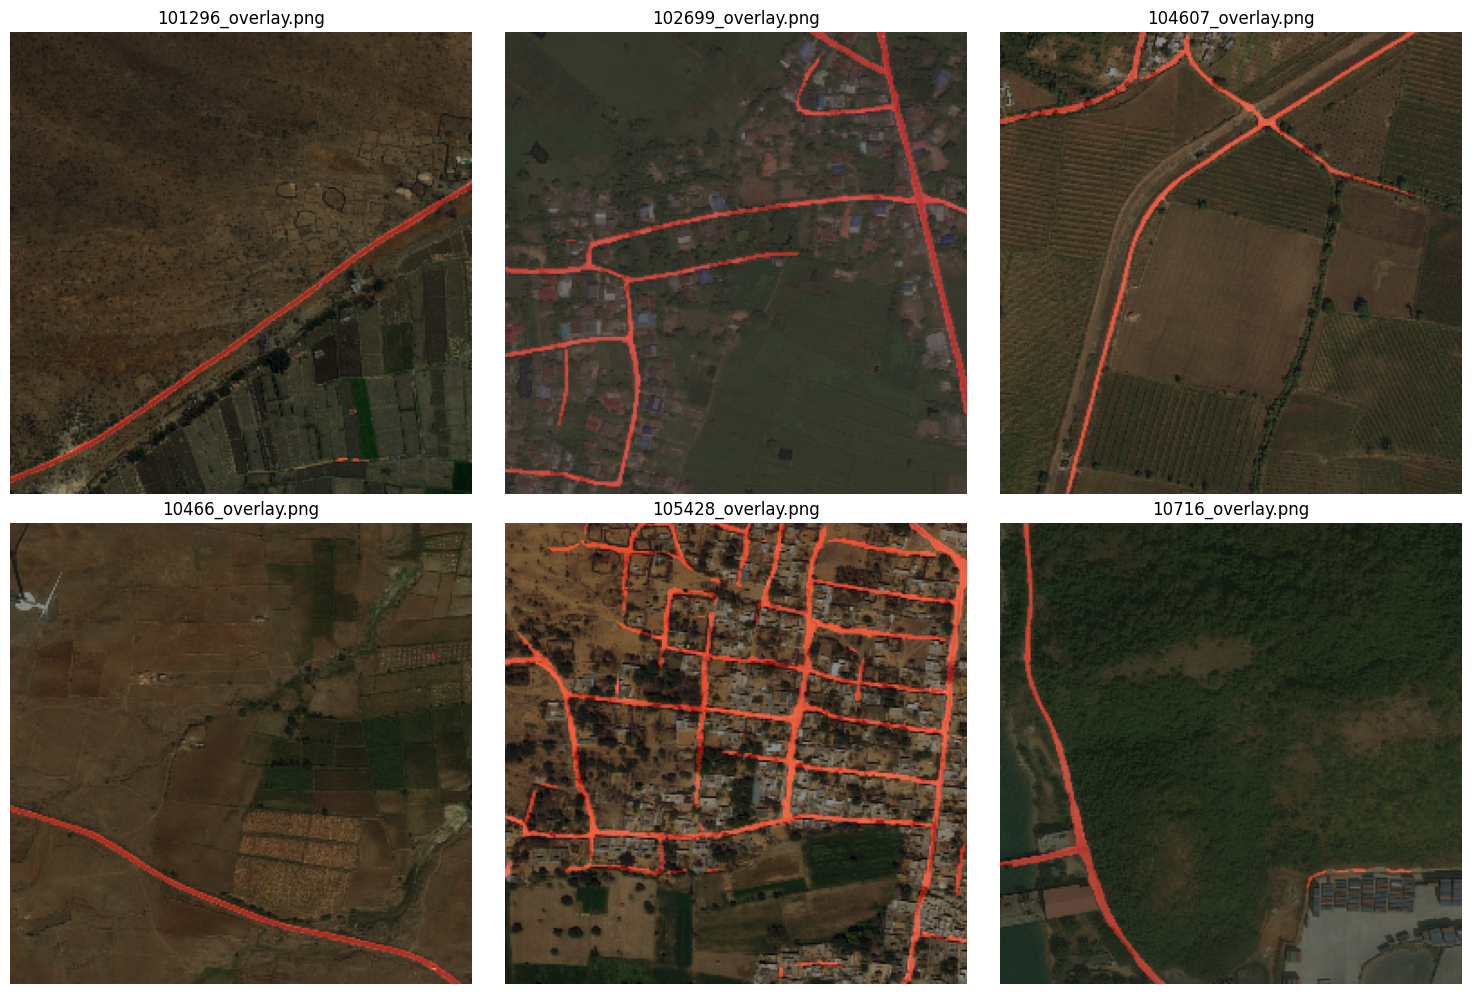

In [19]:
def show_examples(k=6):
    paths = sorted(glob.glob(f"{VIS_DIR}/*_overlay.png"))[:k]
    cols = min(3, k); rows = math.ceil(k/cols)
    plt.figure(figsize=(5*cols,5*rows))
    for i,p in enumerate(paths):
        plt.subplot(rows, cols, i+1)
        plt.imshow(tf.image.decode_png(tf.io.read_file(p)))
        plt.title(os.path.basename(p)); plt.axis('off')
    plt.tight_layout()
show_examples(6)


In [20]:
# a) zip predictions and visuals for easy download
zip_pred = f"{OUTDIR}/predictions.zip"
zip_vis  = f"{OUTDIR}/visuals.zip"
for zpath, folder in [(zip_pred, PRED_DIR), (zip_vis, VIS_DIR)]:
    with zipfile.ZipFile(zpath, "w", compression=zipfile.ZIP_DEFLATED) as z:
        for p in glob.glob(os.path.join(folder, "*.png")):
            z.write(p, arcname=os.path.basename(p))
print("Zipped:", zip_pred, "and", zip_vis)

# b) copy model artifacts alongside outputs (so the next session is trivial)
ARTIFACTS = []
if os.path.exists(BEST_KERAS):   ARTIFACTS.append(BEST_KERAS)
if os.path.exists(BEST_WEIGHTS): ARTIFACTS.append(BEST_WEIGHTS)
for p in ARTIFACTS:
    shutil.copy(p, OUTDIR)
print("Copied artifacts to /kaggle/working:", [os.path.basename(p) for p in ARTIFACTS])


Zipped: /kaggle/working/predictions.zip and /kaggle/working/visuals.zip
Copied artifacts to /kaggle/working: ['unet_best.keras', 'unet_best.weights.h5']


In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{OUTDIR}/unet_ft_best.weights.h5",
        monitor="val_dice_coef", mode="max", save_weights_only=True, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", mode="max", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coef", mode="max", factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks)

# save the fine-tuned model in modern Keras format
model.save(f"{OUTDIR}/unet_ft_best.keras")


Epoch 1/10


2025-09-22 09:50:58.595582: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %convolution.1293 = f16[16,256,256,16]{3,2,1,0} convolution(f16[16,256,256,3]{3,2,1,0} %constant.36, f16[3,3,3,16]{3,2,1,0} %constant.37), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, metadata={op_type="Conv2D" op_name="UNetTiny_1/conv2d_53_1/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1196}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-09-22 09:51:01.327009: E external/local_xla/xla/service/slow_operation_alarm.

  1/312 ━━━━━━━━━━━━━━━━━━━━ 38:10:36 442s/step - accuracy: 0.9807 - dice_coef: 0.6733 - iou_metric: 0.5075 - loss: 0.3974

KeyboardInterrupt: 

In [22]:
history = model.fit(
    train_ds.take(50),         # only 50 batches
    validation_data=val_ds.take(10),
    epochs=2
)


Epoch 1/2
 7/50 ━━━━━━━━━━━━━━━━━━━━ 4:50:30 405s/step - accuracy: 0.9757 - dice_coef: 0.6603 - iou_metric: 0.4930 - loss: 0.4340

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_36/1272808270.py", line 11, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Failed to allocate 67108864 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_97441]

In [1]:
# --- MUST RUN BEFORE `import tensorflow as tf` ---
import os

# Disable XLA/JIT (gets rid of the long "constant folding" stalls and big compile buffers)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"]     = "--xla_cpu_fast_math_honor_infs=false --xla_cpu_fast_math_honor_nans=false"

# Optional: keep TF logs quieter
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import tensorflow as tf

# Let TF grow GPU memory on demand (prevents a big upfront allocation)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("set_memory_growth failed:", e)

print("GPUs:", gpus)


2025-09-22 11:09:38.089535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758539378.406074      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758539378.494599      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# --- paths & basics ---
import os, glob, random, tensorflow as tf

ROOT_IMG = "/kaggle/input/deepglobe-road-extraction-dataset"  # images+masks
IMG_SIZE = 256
BATCH_SIZE = 4   # keep small while we stabilize; we can scale later

# --- collect (image, mask) pairs from train/ ---
sat_files = sorted(glob.glob(os.path.join(ROOT_IMG, "train", "*_sat.jpg")))
pairs = []
for sat in sat_files:
    msk = sat.replace("_sat.jpg", "_mask.png")
    if os.path.exists(msk):
        pairs.append((sat, msk))

print(f"total pairs found: {len(pairs)}")
if len(pairs) == 0:
    raise SystemExit("No train pairs found. Check ROOT_IMG.")

# --- stable 80/20 split for train/val ---
random.Random(42).shuffle(pairs)
n_train = int(len(pairs) * 0.80)
train_split = pairs[:n_train]
val_split   = pairs[n_train:]

print(f"Train: {len(train_split)}  Val: {len(val_split)}")

# --- tf.data helpers ---
AUTOTUNE = tf.data.AUTOTUNE

def _read_image(img_path, msk_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_png(msk, channels=1)           # mask is PNG
    msk = tf.image.resize(msk, (IMG_SIZE, IMG_SIZE), method="nearest")
    # binarize to {0,1}
    msk = tf.cast(msk > 127, tf.float32)
    return img, msk

@tf.function
def _augment(img, msk):
    # light, safe augmentations
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img);    msk = tf.image.flip_up_down(msk)
    return img, msk

def make_ds(pairs, training):
    img_paths = [p[0] for p in pairs]
    msk_paths = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, msk_paths))
    if training:
        ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    ds = ds.map(lambda x,y: _read_image(x,y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_split, training=True)
val_ds   = make_ds(val_split,   training=False)

# quick shape check
xb, yb = next(iter(train_ds.take(1)))
print("train batch:", xb.shape, yb.shape, "mask range:",
      float(tf.reduce_min(yb)), "→", float(tf.reduce_max(yb)))


total pairs found: 6226
Train: 4980  Val: 1246


I0000 00:00:1758539651.870737      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758539651.871450      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


train batch: (4, 256, 256, 3) (4, 256, 256, 1) mask range: 0.0 → 1.0


In [4]:
import tensorflow as tf, os

INSET = "/kaggle/input/22092025"
BEST_KERAS   = os.path.join(INSET, "unet_best.keras")
BEST_WEIGHTS = os.path.join(INSET, "unet_best.weights.h5")
SMALL_KERAS  = os.path.join(INSET, "unet_small.keras")

# ---- metrics & loss (kept simple and robust) ----
bce = tf.keras.losses.BinaryCrossentropy()

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    return tf.reduce_mean((2.0 * inter + smooth) / (union + smooth))

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - inter
    return tf.reduce_mean((inter + smooth) / (union + smooth))

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

# ---- loader ----
model = None
loaded_from = None

try:
    if os.path.exists(BEST_KERAS):
        model = tf.keras.models.load_model(BEST_KERAS, compile=False)
        loaded_from = BEST_KERAS
        print("Loaded:", BEST_KERAS)
    else:
        raise FileNotFoundError(BEST_KERAS)
except Exception as e:
    print("Could not load .keras:", e)
    # requires your builder function to be defined above:
    try:
        model = build_unet_tiny(input_shape=(IMG_SIZE, IMG_SIZE, 3))
        model.load_weights(BEST_WEIGHTS)
        loaded_from = BEST_WEIGHTS
        print("Built UNet and loaded weights:", BEST_WEIGHTS)
    except Exception as e2:
        print("Weights route failed:", e2)
        # last fallback: a smaller keras file (inference)
        model = tf.keras.models.load_model(SMALL_KERAS, compile=False)
        loaded_from = SMALL_KERAS
        print("Loaded fallback:", SMALL_KERAS)

# compile (make sure JIT stays off)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
             dice_coef, iou_metric],
    jit_compile=False
)

# quick sanity: forward on one small batch
xb, yb = next(iter(val_ds.take(1)))
pred = model.predict(xb, verbose=0)
print("pred shape:", pred.shape, "range:", float(pred.min()), "→", float(pred.max()))


Loaded: /kaggle/input/22092025/unet_best.keras


I0000 00:00:1758539687.534641     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


pred shape: (4, 256, 256, 1) range: 0.0 → 1.0


In [5]:
# Step 1: Train the model
EPOCHS = 10

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "unet_ft_best.keras",
        save_best_only=True,
        monitor="val_dice_coef",
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef",
        patience=3,
        restore_best_weights=True,
        mode="max"
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.9739 - dice_coef: 0.6534 - iou_metric: 0.5253 - loss: 0.4377 - val_accuracy: 0.9741 - val_dice_coef: 0.6479 - val_iou_metric: 0.5225 - val_loss: 0.4390
Epoch 2/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9749 - dice_coef: 0.6604 - iou_metric: 0.5334 - loss: 0.4262 - val_accuracy: 0.9751 - val_dice_coef: 0.6532 - val_iou_metric: 0.5251 - val_loss: 0.4339
Epoch 3/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9738 - dice_coef: 0.6575 - iou_metric: 0.5294 - loss: 0.4315 - val_accuracy: 0.9756 - val_dice_coef: 0.6404 - val_iou_metric: 0.5124 - val_loss: 0.4472
Epoch 4/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9743 - dice_coef: 0.6589 - iou_metric: 0.5320 - loss: 0.4289 - val_accuracy: 0.9729 - val_dice_coef: 0.6592 - val_iou_metric: 0.5320 - val_loss: 0.4292
Epoch 5/10
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9746 - dice_coef: 0.6615 - iou_metric: 0.5

In [6]:
# Step 2: Evaluate the model
val_metrics = model.evaluate(val_ds)
print("Validation metrics:", val_metrics)


312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9724 - dice_coef: 0.6593 - iou_metric: 0.5320 - loss: 0.4291
Validation metrics: [0.42916160821914673, 0.9728979468345642, 0.6592002511024475, 0.5320426821708679]


In [7]:
# Save model in modern Keras format
model.save("/kaggle/working/unet_final.keras")

# Save only weights (lighter, for reloading into same architecture)
model.save_weights("/kaggle/working/unet_final.weights.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


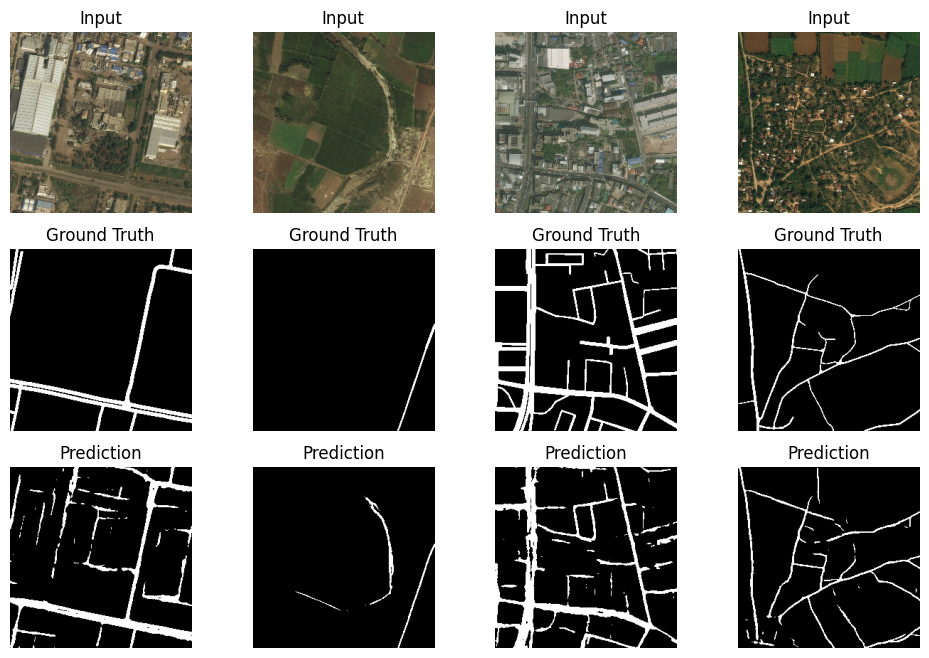

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Take a small batch from validation set
xb, yb = next(iter(val_ds.take(1)))
preds = model.predict(xb)

# Threshold predictions at 0.5
preds_bin = (preds > 0.5).astype(np.uint8)

# Plot a few samples
n = 4
plt.figure(figsize=(12,8))
for i in range(n):
    plt.subplot(3, n, i+1)
    plt.imshow(xb[i].numpy().astype("uint8"))
    plt.title("Input")
    plt.axis("off")

    plt.subplot(3, n, i+1+n)
    plt.imshow(yb[i].numpy().squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, n, i+1+2*n)
    plt.imshow(preds_bin[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
plt.show()


In [9]:
# === QUICK EXPORT (2 batches) ===
import os, numpy as np, matplotlib.pyplot as plt

OUTDIR = "/kaggle/working/preds_quick"
os.makedirs(OUTDIR, exist_ok=True)

num_batches = 2  # change to 10 if you want a bit more
saved = 0

for i, (x, y) in enumerate(val_ds.take(num_batches)):
    pred = model.predict(x, verbose=0)
    pred_bin = (pred > 0.5).astype("uint8")

    # save masks (and optionally inputs) for your report
    for j in range(len(pred_bin)):
        base = f"val_{i:03d}_{j:02d}"
        plt.imsave(os.path.join(OUTDIR, base + "_pred.png"), pred_bin[j].squeeze(), cmap="gray")
        plt.imsave(os.path.join(OUTDIR, base + "_gt.png"),   y[j].numpy().squeeze(), cmap="gray")
        # also save the input tile (uint8 for nice viewing)
        x8 = (np.clip(x[j].numpy(), 0, 1) * 255).astype(np.uint8)
        plt.imsave(os.path.join(OUTDIR, base + "_img.png"), x8)

        saved += 1

print(f"✅ Quick export saved {saved} predictions to {OUTDIR}")


✅ Quick export saved 8 predictions to /kaggle/working/preds_quick


In [10]:
# === FULL EXPORT & ZIP ===
import os, numpy as np, matplotlib.pyplot as plt, zipfile, io

FULL_OUT = "/kaggle/working/preds_full"
os.makedirs(FULL_OUT, exist_ok=True)

count = 0
for i, (x, y) in enumerate(val_ds):  # change to test_ds if that’s your held-out
    pred = model.predict(x, verbose=0)
    pred_bin = (pred > 0.5).astype("uint8")

    for j in range(len(pred_bin)):
        base = f"val_{i:05d}_{j:02d}"
        # save binary prediction
        plt.imsave(os.path.join(FULL_OUT, base + "_pred.png"), pred_bin[j].squeeze(), cmap="gray")
        # optional: save gt & input
        plt.imsave(os.path.join(FULL_OUT, base + "_gt.png"), y[j].numpy().squeeze(), cmap="gray")
        x8 = (np.clip(x[j].numpy(), 0, 1) * 255).astype(np.uint8)
        plt.imsave(os.path.join(FULL_OUT, base + "_img.png"), x8)
        count += 1

print(f"✅ Full export saved {count} triplets to {FULL_OUT}")

# zip the folder for easy download / dataset publish
ZIP_PATH = "/kaggle/working/preds_full.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(FULL_OUT):
        for f in files:
            p = os.path.join(root, f)
            zf.write(p, arcname=os.path.relpath(p, FULL_OUT))
print("📦 Zipped to:", ZIP_PATH)


✅ Full export saved 1246 triplets to /kaggle/working/preds_full
📦 Zipped to: /kaggle/working/preds_full.zip


In [11]:
import json

metrics_dict = {
    "val": {
        "loss": float(val_metrics[0]),
        "accuracy": float(val_metrics[1]),
        "dice": float(val_metrics[2]),
        "iou": float(val_metrics[3]),
    }
}
with open("/kaggle/working/metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=2)

print("✅ Saved /kaggle/working/metrics.json")


✅ Saved /kaggle/working/metrics.json


Saved: /kaggle/working/fig_results.png


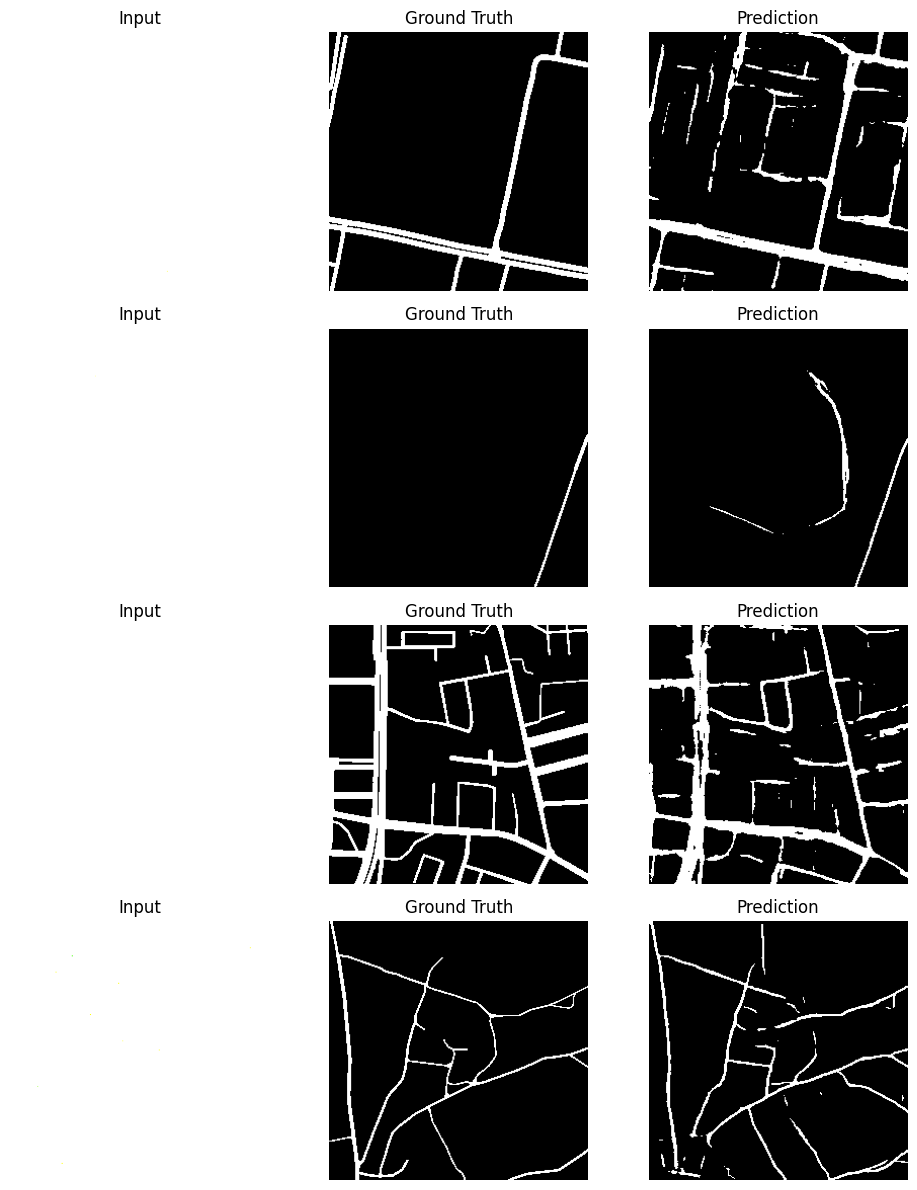

In [12]:
# === FIGURE: 4 samples (Input / GT / Pred) ===
import os, numpy as np, matplotlib.pyplot as plt, glob

# use your quick or full folder
IMG_DIR = "/kaggle/working/preds_quick"   # or "/kaggle/working/preds_full"

triplets = {}
for p in sorted(glob.glob(os.path.join(IMG_DIR, "*_img.png"))):
    stem = p.replace("_img.png","")
    triplets[stem] = (p, stem+"_gt.png", stem+"_pred.png")

keys = list(triplets.keys())[:4]  # 4 examples
fig, axs = plt.subplots(4, 3, figsize=(10, 12))
for r, k in enumerate(keys):
    img_p, gt_p, pr_p = triplets[k]
    axs[r,0].imshow(plt.imread(img_p)); axs[r,0].set_title("Input"); axs[r,0].axis("off")
    axs[r,1].imshow(plt.imread(gt_p), cmap="gray"); axs[r,1].set_title("Ground Truth"); axs[r,1].axis("off")
    axs[r,2].imshow(plt.imread(pr_p), cmap="gray"); axs[r,2].set_title("Prediction"); axs[r,2].axis("off")
plt.tight_layout()
FIG_PATH = "/kaggle/working/fig_results.png"
plt.savefig(FIG_PATH, dpi=200)
print("Saved:", FIG_PATH)


In [13]:
import pandas as pd

# Convert metrics into a small DataFrame
metrics_table = pd.DataFrame([{
    "val_loss": round(float(val_metrics[0]), 4),
    "val_accuracy": round(float(val_metrics[1]), 4),
    "val_dice_coef": round(float(val_metrics[2]), 4),
    "val_iou": round(float(val_metrics[3]), 4)
}])

print(metrics_table)

# Save to CSV (for report)
metrics_table.to_csv("/kaggle/working/metrics_table.csv", index=False)
print("Saved: /kaggle/working/metrics_table.csv")


   val_loss  val_accuracy  val_dice_coef  val_iou
0    0.4292        0.9729         0.6592    0.532
Saved: /kaggle/working/metrics_table.csv


In [14]:
# Save model (for reuse later)
model.save("/kaggle/working/unet_final.keras")
model.save_weights("/kaggle/working/unet_final.weights.h5")

# Save metrics JSON
import json
with open("/kaggle/working/val_metrics.json", "w") as f:
    json.dump({
        "val_loss": float(val_metrics[0]),
        "val_accuracy": float(val_metrics[1]),
        "val_dice_coef": float(val_metrics[2]),
        "val_iou": float(val_metrics[3])
    }, f, indent=2)

print("Saved all artifacts: model, weights, metrics, figure")


Saved all artifacts: model, weights, metrics, figure


Saved: /kaggle/working/training_curves.png


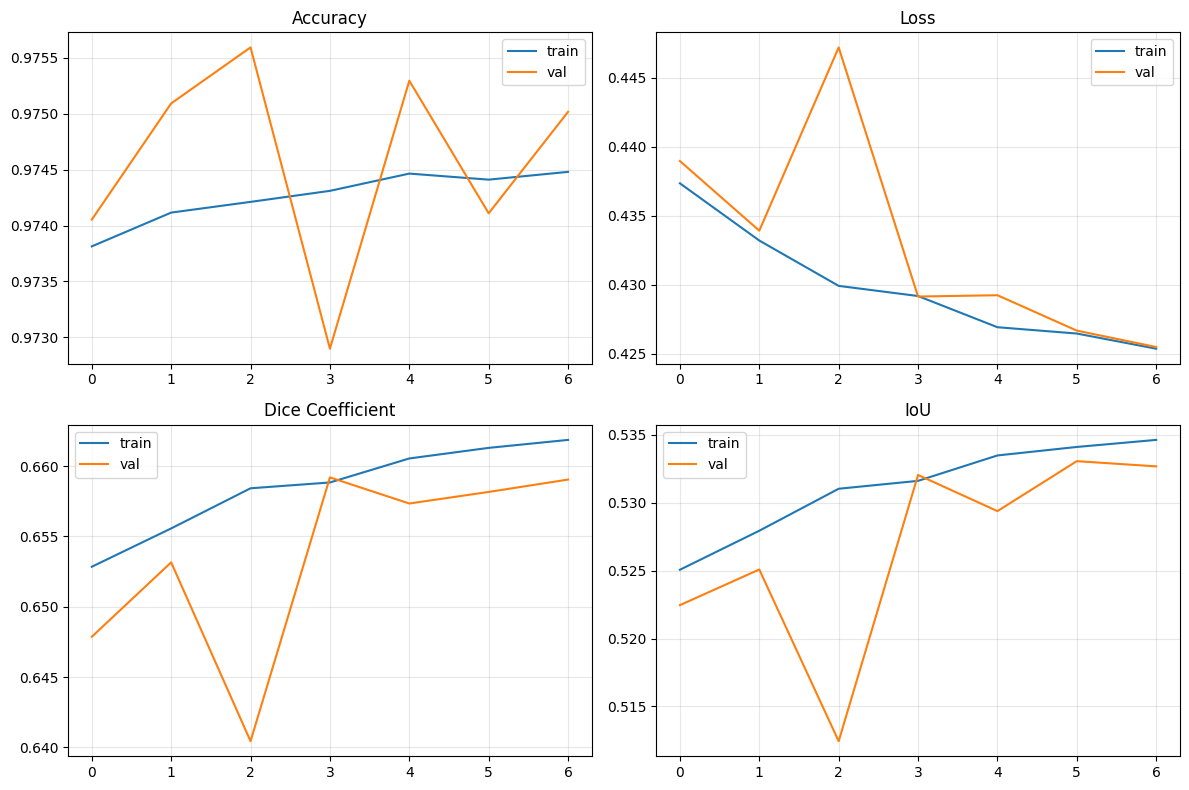

In [15]:
# STEP 1 — Plot training curves and save a figure for the report
import matplotlib.pyplot as plt
import os

assert 'history' in globals(), "history is not in memory. Re-run the training cell that produced `history`."

h = history.history
def _vals(key): 
    return h.get(key, [])

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(_vals('accuracy'), label='train')
plt.plot(_vals('val_accuracy'), label='val')
plt.title('Accuracy'); plt.legend(); plt.grid(True, alpha=.3)

plt.subplot(2,2,2)
plt.plot(_vals('loss'), label='train')
plt.plot(_vals('val_loss'), label='val')
plt.title('Loss'); plt.legend(); plt.grid(True, alpha=.3)

plt.subplot(2,2,3)
plt.plot(_vals('dice_coef'), label='train')
plt.plot(_vals('val_dice_coef'), label='val')
plt.title('Dice Coefficient'); plt.legend(); plt.grid(True, alpha=.3)

plt.subplot(2,2,4)
plt.plot(_vals('iou_metric'), label='train')
plt.plot(_vals('val_iou_metric'), label='val')
plt.title('IoU'); plt.legend(); plt.grid(True, alpha=.3)

plt.tight_layout()
FIG_CURVES = "/kaggle/working/training_curves.png"
plt.savefig(FIG_CURVES, dpi=150)
print("Saved:", FIG_CURVES)
plt.show()


In [16]:
# STEP 2 — Compute pixel-wise confusion stats on part of validation set and save JSON
import numpy as np, json, tensorflow as tf

THRESHOLD = 0.5          # prediction threshold
N_VAL_BATCHES = 20       # how many validation batches to scan (keep modest for speed/memory)

tp = fp = tn = fn = 0
seen_imgs = 0

for xb, yb in val_ds.take(N_VAL_BATCHES):
    # forward pass without building a new graph
    pred = model(xb, training=False)

    y_true = tf.cast(yb > 0.5, tf.int32).numpy()
    y_pred = tf.cast(pred > THRESHOLD, tf.int32).numpy()

    tp += np.sum((y_true == 1) & (y_pred == 1))
    tn += np.sum((y_true == 0) & (y_pred == 0))
    fp += np.sum((y_true == 0) & (y_pred == 1))
    fn += np.sum((y_true == 1) & (y_pred == 0))
    seen_imgs += xb.shape[0]

precision = tp / (tp + fp + 1e-9)
recall    = tp / (tp + fn + 1e-9)
f1        = 2 * precision * recall / (precision + recall + 1e-9)
iou       = tp / (tp + fp + fn + 1e-9)

print(f"Scanned {seen_imgs} images  |  TP:{tp}  FP:{fp}  TN:{tn}  FN:{fn}")
print(f"Precision:{precision:.4f}  Recall:{recall:.4f}  F1:{f1:.4f}  IoU:{iou:.4f}")

stats = {
    "threshold": float(THRESHOLD),
    "seen_images": int(seen_imgs),
    "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    "precision": float(precision), "recall": float(recall),
    "f1": float(f1), "iou": float(iou)
}
OUT = "/kaggle/working/val_confusion_stats.json"
with open(OUT, "w") as f:
    json.dump(stats, f, indent=2)
print("Saved:", OUT)


Scanned 80 images  |  TP:176104  FP:90241  TN:4917123  FN:59412
Precision:0.6612  Recall:0.7477  F1:0.7018  IoU:0.5406
Saved: /kaggle/working/val_confusion_stats.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


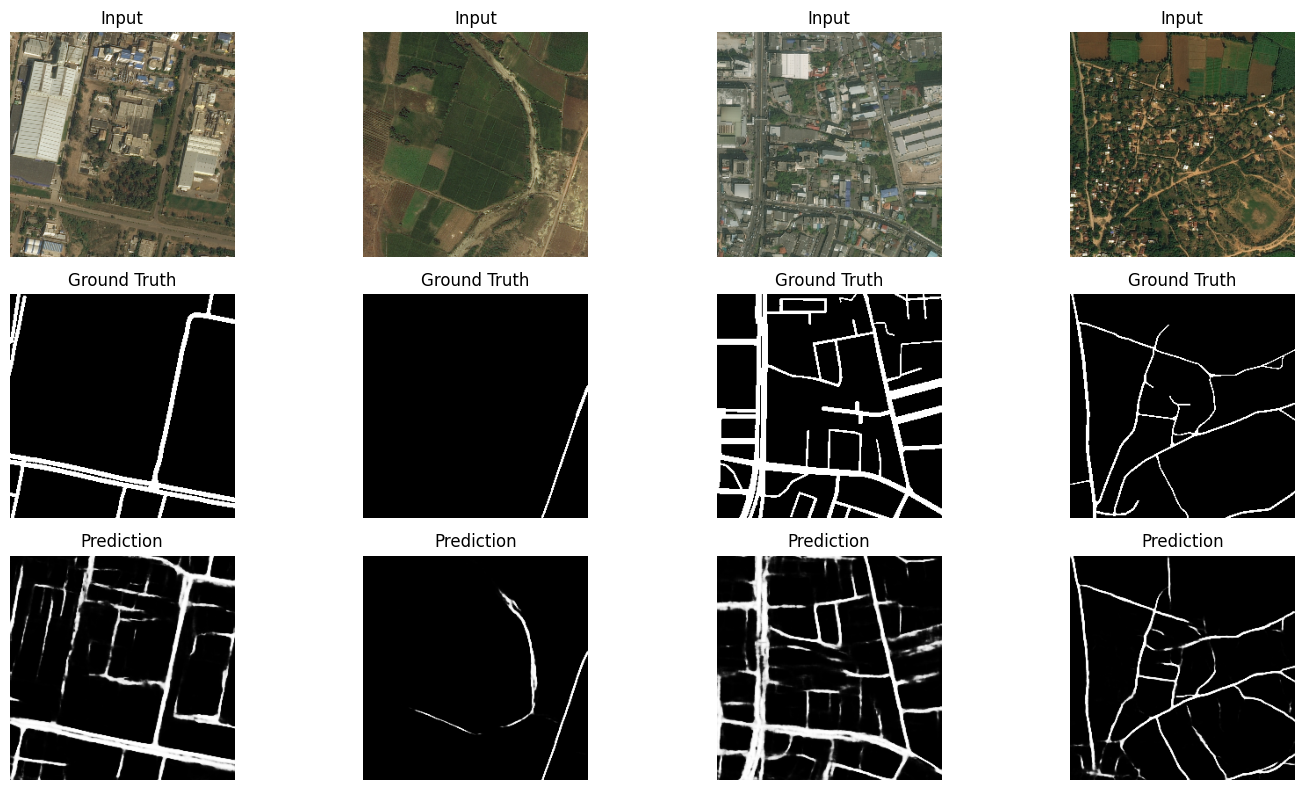

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


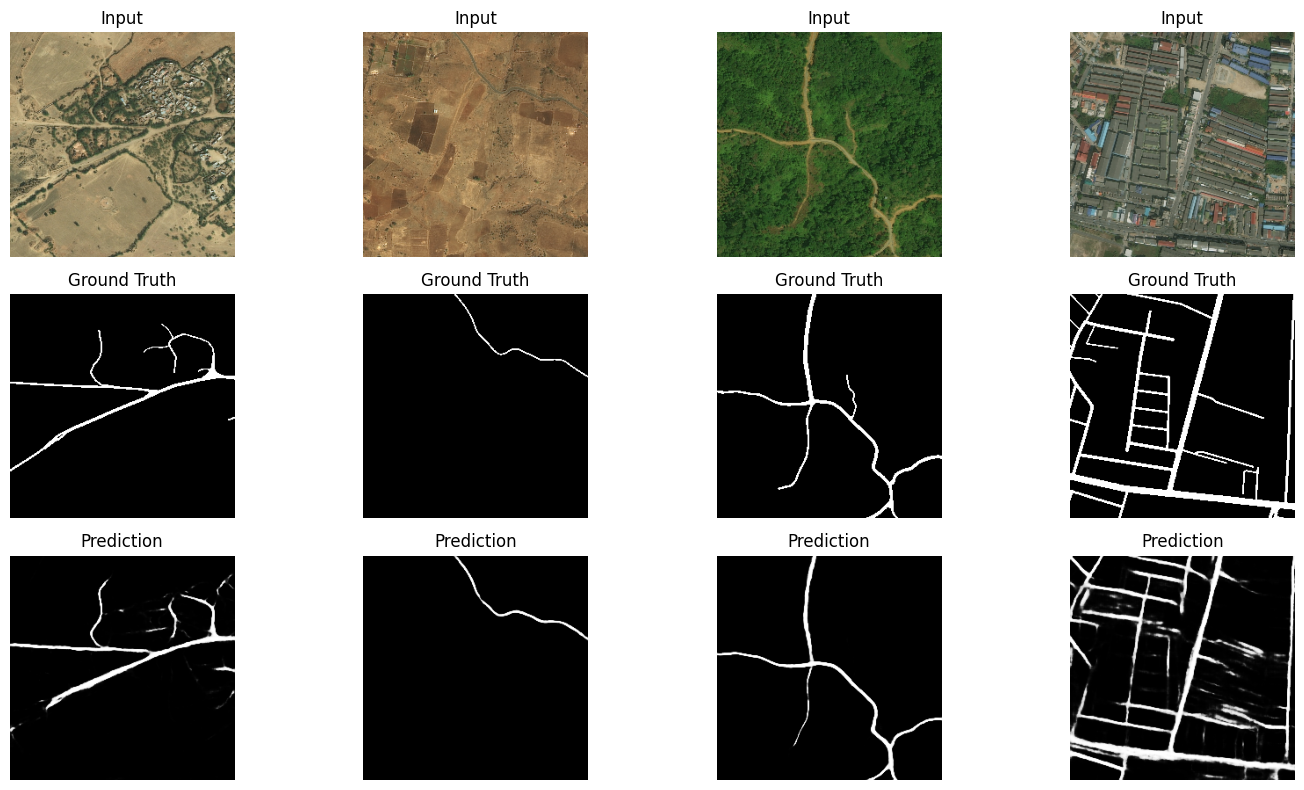

In [17]:
import matplotlib.pyplot as plt

# Visualize some predictions overlayed on input images
for img, mask in val_ds.take(2):   # just a couple of batches
    pred = model.predict(img)
    fig, axes = plt.subplots(3, img.shape[0], figsize=(15, 8))
    for i in range(img.shape[0]):
        axes[0,i].imshow(img[i].numpy().astype("uint8"))
        axes[0,i].set_title("Input")
        axes[0,i].axis("off")
        
        axes[1,i].imshow(mask[i].numpy().squeeze(), cmap="gray")
        axes[1,i].set_title("Ground Truth")
        axes[1,i].axis("off")
        
        axes[2,i].imshow(pred[i].squeeze(), cmap="gray")
        axes[2,i].set_title("Prediction")
        axes[2,i].axis("off")
    plt.tight_layout()
    plt.show()


In [18]:
plt.savefig("/kaggle/working/training_curves.png")


<Figure size 640x480 with 0 Axes>

In [19]:
import os
os.listdir("/kaggle/working")


['val_metrics.json',
 'val_confusion_stats.json',
 'preds_quick',
 'metrics.json',
 'fig_results.png',
 'unet_final.keras',
 'unet_ft_best.keras',
 'training_curves.png',
 'metrics_table.csv',
 'unet_final.weights.h5',
 'preds_full',
 'preds_full.zip',
 '.virtual_documents']